<h1 align = "center" > Quantitative Structure-Activity Relationship (QSAR) Modelling of human acetylcholinesterase inhibitors</h1>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/acetylcholinesterase_2016/acetylcholinesterase_2016.ipynb)

### Project Content

1. [Introduction](#1)
    * 1.1 [Examining the Project Topic](#2)
2. [Data pre-processing](#3)
    * 2.1 [ChEMBL Database](#4)
        - 2.1.1 [Importing libraries](#5)
        - 2.1.2 [Search for Target Protein](#6)
        - 2.1.3 [Select and retrieve bioactivity data for Human Acetylcholinesterase](#7)
        - 2.1.4 [Retrieve Bioactivity Data](#8)
    * 2.2. [Missing Data](#9)
    * 2.3. [Labeling compounds as active, intermediate or inactive](#10)
3. [Exploratory Data Analysis](#11)
    * 3.1 [Installing conda and rdkit](#12)
    * 3.2 [Importing Libraries](#13)
    * 3.3 [Lipinski Descriptors](#14)
        - 3.3.1 [Lipinski's Rule of Five](#15)
        - 3.3.2 [Cleaning SMILE](#16)
        - 3.3.3 [Calculate Descriptors](#17)
    * 3.4 [Convert IC50 to pIC50](#18)
        - 3.4.1 [Countplot](#19)
        - 3.4.2 [Scatter plot](#20)
            * 3.4.2.1 [Descriptors vs pIC50](#21)
            * 3.4.2.2 [Descriptors](#22)
        - 3.4.3 [Pair Plot of Descriptors vs pIC50](#23)
        - 3.4.4 [Box Plot](#24)
    * 3.5 [Statistical analysis | Mann-Whitney U Test](#25)
        - 3.5.1 [pIC50](#26)
        - 3.5.2 [Molecular Weight (MW)](#27)
        - 3.5.3 [Octanol-Water Partition Coefficient (LogP)](#28)
        - 3.5.4 [Number of Hydron Donors (NumHDonors)](#29)
        - 3.5.5 [Number of Hydron Acceptors (NumHAcceptors)](#30)
        - 3.5.6 [Interpretation of the Statistical Results](#31)
    * 3.6 [PaDEL Descriptors](#32)
        - 3.6.1 [Download PaDEL-Descriptor](#33)
        - 3.6.2 [Loading the Bioactivity Data](#34)
        - 3.6.3 [Calculate the Fingerprint Descriptors](#35)
        - 3.6.4 [Preparing the X and Y Matrices](#36)
            * 3.6.4.1 [X-Matrix](#37)
            * 3.6.4.2 [Y-Variable](#38)
            * 3.6.4.3 [Combining the X and Y Variables](#39)
4. [Regression Models Evaluation](#40)
    - 4.1 [Importing Libraries](#41)
    - 4.2 [Load X and Y](#42)
    - 4.3 [Drop Low Variance Features](#43)
    - 4.4 [Splitting Test and Train Sets](#44)
    - 4.5 [Comparing Machine Learning Algorithms](#45)
        * 4.5.5 [Visualization](#46)
    - 4.6 [Analysis of Model Performance](#47)
5. [Random Forest](#48)
    - 5.1 [Importing Libraries](#49)
    - 5.2 [Input Features](#50)
    - 5.3 [Random Forest Regression Model](#51)
    - 5.4 [Experimental vs Prediced pIC50 Values](#52)
    - 5.5 [Residuals](#53)
    - 5.6 [Analysis of the Visualizations](#54)
6. [Hyperparameters](#55)
    - 6.1 [Importing Library](#56)
    - 6.2 [Defining the Hyperparameters Grid](#57)
    - 6.3 [Initializing the RandomizedGridCV](#58)
    - 6.4 [Results](#59)
7. [10-Fold Cross-Validation](#60)
    - 7.1 [Importing Libraries](#61)
    - 7.2 [Set Up the 10-Fold CV](#62)
    - 7.3 [Results](#63)
8. [Conclusions](#64)
9. [References](#65)


# 1. Introduction<a id = 1></a>

## 1.1 Examining the Project Topic<a id = 2></a>

Acetylcholinesterase (AChE) is a crucial enzyme primarily found in the synapses and neuromuscular junctions, where its primary function is to terminate neurotransmission by rapidly hydrolyzing the neurotransmitter acetylcholine (ACh).<sup><a href="#ref1">[1]</a></sup> AChE plays a significant role in various physiological processes, including muscle contraction, cognition, and the regulation of certain secretions. Dysregulation or inhibition of AChE activity can lead to conditions such as Alzheimer's disease and can be the target of certain toxins and nerve agents.<sup><a href="#ref2">[2]</a></sup> In the context of insecticide resistance, mutations in AChE can lead to resistance against certain chemicals, highlighting its importance in pest management.<sup><a href="#ref3">[3]</a></sup> Recent research has also indicated that AChE might have non-cholinergic functions, potentially playing a role in cellular development and apoptosis.<sup><a href="#ref4">[4]</a></sup>

In the context of this work, I will reproduce the published research paper<sup><a href="#ref5">[5]</a></sup>: https://doi.org/10.7717/peerj.2322

Here the authors, analyzed a dataset of 2,570 compounds from ChEMBL to study their bioactivity against Acetylcholinesterase (AChE) using quantitative structure-activity relationship (QSAR)<sup><a href="#ref6">[6]</a></sup> methods. Using fingerprint descriptors and random forest algorithms, they developed predictive models with good accuracy.

**Note**: This project was inspired by the work of [dataprofessor](https://github.com/dataprofessor). While the original framework was provided by dataprofessor, modifications, updates, and additional information were incorporated to enhance the analysis.

# 2. Data Pre-processing<a id = 3></a>

## 2.1 ChEMBL Database<a id = 4></a>

ChEMBL is a database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity, and genomic data to aid the translation of genomic information into effective new drugs. The ChEMBL database contains a vast amount of bioactivity data sourced from scientific literature, specifically focusing on the properties and activities of drug-like molecules. It's a valuable resource for drug discovery and chemical biology research.<sup><a href="#ref7">[7]</a></sup>

### 2.1.1 Importing libraries<a id = 5></a>

In [1]:
pip install --upgrade pip

In [2]:
! pip install chembl_webresource_client

In [3]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

### 2.1.2 Search for Target Protein<a id = 6></a>

In [4]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
targets

cross_references  \
0   [{'xref_id': 'P22303', 'xref_name': None, 'xre...   
1                                                  []   
2                                                  []   
3                                                  []   
4                                                  []   
5   [{'xref_id': 'P04058', 'xref_name': None, 'xre...   
6   [{'xref_id': 'P21836', 'xref_name': None, 'xre...   
7   [{'xref_id': 'P37136', 'xref_name': None, 'xre...   
8   [{'xref_id': 'O42275', 'xref_name': None, 'xre...   
9   [{'xref_id': 'P23795', 'xref_name': None, 'xre...   
10                                                 []   
11                                                 []   
12                                                 []   
13                                                 []   
14                                                 []   
15  [{'xref_id': 'Q95P20', 'xref_name': None, 'xre...   
16                                                 []   
17                                                 []   
18                                                 []   
19                                                 []   
20                                                 []   
21                                                 []   
22                                                 []   
23                                                 []   

                     organism  \
0                Homo sapiens   
1                Homo sapiens   
2     Drosophila melanogaster   
3              Bemisia tabaci   
4   Leptinotarsa decemlineata   
5         Torpedo californica   
6                Mus musculus   
7           Rattus norvegicus   
8    Electrophorus electricus   
9                  Bos taurus   
10          Anopheles gambiae   
11     Nephotettix cincticeps   
12              Gallus gallus   
13                Danio rerio   
14              Aedes aegypti   
15            Musca domestica   
16          Rattus norvegicus   
17        Plutella xylostella   
18            Musca domestica   
19  Pediculus humanus capitis   
20          Spodoptera litura   
21      Laodelphax striatella   
22        Schizaphis graminum   
23     Caenorhabditis elegans   

                                            pref_name  score  \
0                                Acetylcholinesterase   27.0   
1                        Cholinesterases; ACHE & BCHE   27.0   
2                                Acetylcholinesterase   18.0   
3                                               AChE2   16.0   
4                                Acetylcholinesterase   16.0   
5                                Acetylcholinesterase   15.0   
6                                Acetylcholinesterase   15.0   
7                                Acetylcholinesterase   15.0   
8                                Acetylcholinesterase   15.0   
9                                Acetylcholinesterase   15.0   
10                               Acetylcholinesterase   15.0   
11               Ace-orthologous acetylcholinesterase   15.0   
12                               Acetylcholinesterase   15.0   
13                               Acetylcholinesterase   15.0   
14                               Acetylcholinesterase   15.0   
15                               Acetylcholinesterase   14.0   
16  Acetylcholinesterase and butyrylcholinesterase...   14.0   
17                               Acetylcholinesterase   14.0   
18                               Acetylcholinesterase   14.0   
19                               Acetylcholinesterase   14.0   
20                               Acetylcholinesterase   14.0   
21                               Acetylcholinesterase   14.0   
22                               Acetylcholinesterase   14.0   
23                             Acetylcholinesterase 1   14.0   

    species_group_flag target_chembl_id  \
0                False        CHEMBL220   
1                False    CHEMBL2095233   
2                False    CHEMBL2242744   
3           

## Summary of Target Proteins Table

### Columns:

- **cross_references**: Contains cross-reference IDs for the target proteins.
- **organism**: The organism from which the target protein originates.
- **pref_name**: The preferred name of the target protein.
- **score**: A numerical score associated with the target protein indicating relevance.
- **species_group_flag**: A boolean flag indicating if the target is a species group.
- **target_chembl_id**: The unique ChEMBL ID for the target protein.
- **target_components**: Contains accession numbers and descriptions of target components.
- **target_type**: Type of the target (e.g., SINGLE PROTEIN, SELECTIVITY GROUP).
- **tax_id**: Taxonomy ID for the organism.

### Key Insights:

- The majority of the targets are of type "SINGLE PROTEIN".
- The organisms range from common ones like "Homo sapiens" (Humans) and "Mus musculus" (Mice) to more specific ones like "Electrophorus electricus" (Electric eel) and "Pediculus humanus capitis" (Head louse).
- The highest score observed is 27.0, associated with Acetylcholinesterase in humans and the group "Cholinesterases; ACHE & BCHE" in humans.
- Some targets have cross-reference IDs, while others don't.
- The table contains 24 entries.


### 2.1.3 Select and retrieve bioactivity data for Human Acetylcholinesterase<a id = 7></a>

Now, I will get the ChEMBL ID and with it the biological data from **pChEMBL** wich is a normalized bioactivity value, often used to represent IC50, EC50, etc., in a consistent manner. The pChEMBL value is particularly useful because it allows for the comparison of bioactivity data across different units and assay types.

The pChEMBL value is calculated as:

$$ pChEMBL=−log⁡10(molarIC50,EC50,etc.)pChEMBL=−log10​(molarIC50,EC50,etc.) $$

For example, if a compound has an IC50 value of 1 µM (microMolar), its pChEMBL value would be:

$$ pChEMBL=−log⁡10(1×10-6)=6pChEMBL=−log10​(1×10−6)=6 $$

In [5]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL220'

### 2.1.4 Retrieve Bioactivity Data<a id = 8></a>

In [10]:
activity = new_client.activity
bioactivities = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [11]:
df = pd.DataFrame.from_dict(bioactivities)
df

action_type activity_comment  \
0                                                  None             None   
1                                                  None             None   
2                                                  None             None   
3                                                  None             None   
4                                                  None             None   
...                                                 ...              ...   
8827  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8828  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8829  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8830  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8831  {'action_type': 'INHIBITOR', 'description': 'N...             None   

      activity_id                                activity_properties  \
0           33969                                                 []   
1           37563                                                 []   
2           37565                                                 []   
3           38902                                                 []   
4           41170                                                 []   
...           ...                                                ...   
8827     24963385  [{'comments': None, 'relation': '=', 'result_f...   
8828     24965328                                                 []   
8829     24965329                                                 []   
8830     24965330                                                 []   
8831     24970582                                                 []   

     assay_chembl_id                                  assay_description  \
0       CHEMBL643384  Inhibitory concentration against acetylcholine...   
1       CHEMBL643384  Inhibitory concentration against acetylcholine...   
2       CHEMBL643384  Inhibitory concentration against acetylcholine...   
3       CHEMBL643384  Inhibitory concentration against acetylcholine...   
4       CHEMBL643384  Inhibitory concentration against acetylcholine...   
...              ...                                                ...   
8827   CHEMBL5216448  Inhibition of recombinant human AChE using ace...   
8828   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8829   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8830   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8831   CHEMBL5218078  Inhibition of acetylcholinesterase (unknown or...   

     assay_type assay_variant_accession assay_variant_mutation bao_endpoint  \
0             B                    None                   None  BAO_0000190   
1             B                    None                   None  BAO_0000190   
2             B                    None                   None  BAO_0000190   
3             B                    None                   None  BAO_0000190   
4             B                    None                   None  BAO_0000190   
...         ...                     ...                    ...          ...   
8827          B                    None                   None  BAO_0000190   
8828          B                    None                   None  BAO_0000190   
8829          B                    None                   None  BAO_0000190   
8830          B                    None                   None  BAO_0000190   
8831          B                    None                   None  BAO_0000190   

      ... target_organism      target_pref_name target_tax_id text_value  \
0     ...    Homo sapiens  Acetylcholinesterase          9606       None   
1     ...    Homo sapiens  Acetylcholinesterase          9606       None   
2     ...    Homo sapiens  Acetylcholinesterase          9606       None   
3     ...    Homo sapiens  Acetylcholinesterase          9606       None   
4     ...    Homo sapiens  Acetylcho

In [12]:
df.to_csv('acetylcholinesterase_bioactivity_data_raw.csv', index=False)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
! ls -l

total 4884
-rw-r--r-- 1 root root 4990824 Oct  2 08:59 acetylcholinesterase_bioactivity_data_raw.csv
drwx------ 6 root root    4096 Oct  2 07:29 drive
drwxr-xr-x 1 root root    4096 Sep 28 13:26 sample_data


In [17]:
! mkdir "/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/"

In [18]:
!ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/

total 0


In [20]:
! mkdir "/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/"

In [21]:
!cp acetylcholinesterase_bioactivity_data_raw.csv /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/

In [22]:
! ls /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/

acetylcholinesterase_bioactivity_data_raw.csv


In [23]:
! head /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_raw.csv

action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
,,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholinesterase,B,,,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,,,CHEMBL1148382,J Med Chem,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', 'sei': '9.21'}",CHEMBL133897,,CHEMBL133897,6.12,0,http://www.op

## 2.2 Missing Data<a id = 9></a>

If any compounds has missing value for the **standard_value** and **canonical_smiles** column then drop it.

### 1. **standard_value:**
- The `standard_value` column represents the potency or activity measurement of a compound against a particular biological target, in this particular case against acetylcholinesterase.
- It quantifies how much of a compound (or drug) is needed to produce a specific effect.
- The specific type of measurement (e.g., IC50, EC50, Ki, etc.) is usually indicated in another column, often named `standard_type`.
- The units of `standard_value` (e.g., nM, µM, etc.) are typically provided in another column, often named `standard_units`.
- For example, an IC50 value in the `standard_value` column indicates the concentration of the compound required to inhibit a biological process by 50%.

### 2. **canonical_smiles:**
- The `canonical_smiles` column contains the Simplified Molecular Input Line Entry System (SMILES) representation of the chemical structure of compounds.
- SMILES is a notation that allows a user to represent a chemical structure as a text string. It's a way to encode the structure of a molecule in a compact and human-readable form.
- The "canonical" form refers to a standardized version of the SMILES string, ensuring that a given molecule will always be represented by the same canonical SMILES, regardless of the method used to generate the SMILES string.

Both of these columns are crucial in cheminformatics and drug discovery processes. The `standard_value` provides insights into the potency of compounds, while the `canonical_smiles` allows for the representation, comparison, and analysis of chemical structures using computational tools.


In [24]:
df2 = df[df.standard_value.notna()]
df2

action_type activity_comment  \
0                                                  None             None   
1                                                  None             None   
2                                                  None             None   
3                                                  None             None   
4                                                  None             None   
...                                                 ...              ...   
8827  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8828  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8829  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8830  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8831  {'action_type': 'INHIBITOR', 'description': 'N...             None   

      activity_id                                activity_properties  \
0           33969                                                 []   
1           37563                                                 []   
2           37565                                                 []   
3           38902                                                 []   
4           41170                                                 []   
...           ...                                                ...   
8827     24963385  [{'comments': None, 'relation': '=', 'result_f...   
8828     24965328                                                 []   
8829     24965329                                                 []   
8830     24965330                                                 []   
8831     24970582                                                 []   

     assay_chembl_id                                  assay_description  \
0       CHEMBL643384  Inhibitory concentration against acetylcholine...   
1       CHEMBL643384  Inhibitory concentration against acetylcholine...   
2       CHEMBL643384  Inhibitory concentration against acetylcholine...   
3       CHEMBL643384  Inhibitory concentration against acetylcholine...   
4       CHEMBL643384  Inhibitory concentration against acetylcholine...   
...              ...                                                ...   
8827   CHEMBL5216448  Inhibition of recombinant human AChE using ace...   
8828   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8829   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8830   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8831   CHEMBL5218078  Inhibition of acetylcholinesterase (unknown or...   

     assay_type assay_variant_accession assay_variant_mutation bao_endpoint  \
0             B                    None                   None  BAO_0000190   
1             B                    None                   None  BAO_0000190   
2             B                    None                   None  BAO_0000190   
3             B                    None                   None  BAO_0000190   
4             B                    None                   None  BAO_0000190   
...         ...                     ...                    ...          ...   
8827          B                    None                   None  BAO_0000190   
8828          B                    None                   None  BAO_0000190   
8829          B                    None                   None  BAO_0000190   
8830          B                    None                   None  BAO_0000190   
8831          B                    None                   None  BAO_0000190   

      ... target_organism      target_pref_name target_tax_id text_value  \
0     ...    Homo sapiens  Acetylcholinesterase          9606       None   
1     ...    Homo sapiens  Acetylcholinesterase          9606       None   
2     ...    Homo sapiens  Acetylcholinesterase          9606       None   
3     ...    Homo sapiens  Acetylcholinesterase          9606       None   
4     ...    Homo sapiens  Acetylcho

In [25]:
df2 = df2[df2.canonical_smiles.notna()]
df2

action_type activity_comment  \
0                                                  None             None   
1                                                  None             None   
2                                                  None             None   
3                                                  None             None   
4                                                  None             None   
...                                                 ...              ...   
8827  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8828  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8829  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8830  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8831  {'action_type': 'INHIBITOR', 'description': 'N...             None   

      activity_id                                activity_properties  \
0           33969                                                 []   
1           37563                                                 []   
2           37565                                                 []   
3           38902                                                 []   
4           41170                                                 []   
...           ...                                                ...   
8827     24963385  [{'comments': None, 'relation': '=', 'result_f...   
8828     24965328                                                 []   
8829     24965329                                                 []   
8830     24965330                                                 []   
8831     24970582                                                 []   

     assay_chembl_id                                  assay_description  \
0       CHEMBL643384  Inhibitory concentration against acetylcholine...   
1       CHEMBL643384  Inhibitory concentration against acetylcholine...   
2       CHEMBL643384  Inhibitory concentration against acetylcholine...   
3       CHEMBL643384  Inhibitory concentration against acetylcholine...   
4       CHEMBL643384  Inhibitory concentration against acetylcholine...   
...              ...                                                ...   
8827   CHEMBL5216448  Inhibition of recombinant human AChE using ace...   
8828   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8829   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8830   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8831   CHEMBL5218078  Inhibition of acetylcholinesterase (unknown or...   

     assay_type assay_variant_accession assay_variant_mutation bao_endpoint  \
0             B                    None                   None  BAO_0000190   
1             B                    None                   None  BAO_0000190   
2             B                    None                   None  BAO_0000190   
3             B                    None                   None  BAO_0000190   
4             B                    None                   None  BAO_0000190   
...         ...                     ...                    ...          ...   
8827          B                    None                   None  BAO_0000190   
8828          B                    None                   None  BAO_0000190   
8829          B                    None                   None  BAO_0000190   
8830          B                    None                   None  BAO_0000190   
8831          B                    None                   None  BAO_0000190   

      ... target_organism      target_pref_name target_tax_id text_value  \
0     ...    Homo sapiens  Acetylcholinesterase          9606       None   
1     ...    Homo sapiens  Acetylcholinesterase          9606       None   
2     ...    Homo sapiens  Acetylcholinesterase          9606       None   
3     ...    Homo sapiens  Acetylcholinesterase          9606       None   
4     ...    Homo sapiens  Acetylcho

In [26]:
len(df2.canonical_smiles.unique())

6157

In [27]:
df2_no_duplicates = df2.drop_duplicates(['canonical_smiles'])
df2_no_duplicates

action_type activity_comment  \
0                                                  None             None   
1                                                  None             None   
2                                                  None             None   
3                                                  None             None   
4                                                  None             None   
...                                                 ...              ...   
8825  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8827  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8828  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8829  {'action_type': 'INHIBITOR', 'description': 'N...             None   
8831  {'action_type': 'INHIBITOR', 'description': 'N...             None   

      activity_id                                activity_properties  \
0           33969                                                 []   
1           37563                                                 []   
2           37565                                                 []   
3           38902                                                 []   
4           41170                                                 []   
...           ...                                                ...   
8825     24963372  [{'comments': None, 'relation': '=', 'result_f...   
8827     24963385  [{'comments': None, 'relation': '=', 'result_f...   
8828     24965328                                                 []   
8829     24965329                                                 []   
8831     24970582                                                 []   

     assay_chembl_id                                  assay_description  \
0       CHEMBL643384  Inhibitory concentration against acetylcholine...   
1       CHEMBL643384  Inhibitory concentration against acetylcholine...   
2       CHEMBL643384  Inhibitory concentration against acetylcholine...   
3       CHEMBL643384  Inhibitory concentration against acetylcholine...   
4       CHEMBL643384  Inhibitory concentration against acetylcholine...   
...              ...                                                ...   
8825   CHEMBL5216438  Binding affinity to AChE (unknown origin) asse...   
8827   CHEMBL5216448  Inhibition of recombinant human AChE using ace...   
8828   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8829   CHEMBL5217010  Inhibition of human recombinant AChE using S-a...   
8831   CHEMBL5218078  Inhibition of acetylcholinesterase (unknown or...   

     assay_type assay_variant_accession assay_variant_mutation bao_endpoint  \
0             B                    None                   None  BAO_0000190   
1             B                    None                   None  BAO_0000190   
2             B                    None                   None  BAO_0000190   
3             B                    None                   None  BAO_0000190   
4             B                    None                   None  BAO_0000190   
...         ...                     ...                    ...          ...   
8825          B                    None                   None  BAO_0000190   
8827          B                    None                   None  BAO_0000190   
8828          B                    None                   None  BAO_0000190   
8829          B                    None                   None  BAO_0000190   
8831          B                    None                   None  BAO_0000190   

      ... target_organism      target_pref_name target_tax_id text_value  \
0     ...    Homo sapiens  Acetylcholinesterase          9606       None   
1     ...    Homo sapiens  Acetylcholinesterase          9606       None   
2     ...    Homo sapiens  Acetylcholinesterase          9606       None   
3     ...    Homo sapiens  Acetylcholinesterase          9606       None   
4     ...    Homo sapiens  Acetylcho

## 2.3. Labeling compounds as active, intermediate or inactive<a id = 10></a>

In [28]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_no_duplicates[selection]
df3

molecule_chembl_id                                   canonical_smiles  \
0          CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1          CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2          CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   
3          CHEMBL130628      O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F   
4          CHEMBL130478          CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C   
...                 ...                                                ...   
8825      CHEMBL5219841         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1   
8827      CHEMBL5219046      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1   
8828      CHEMBL5219594             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1   
8829      CHEMBL5219958         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1   
8831      CHEMBL5220884  Cn1ccc2cc(-c3cnc4ccc(C(=O)N5CCCCC5)cc4n3)ccc2c1=O   

     standard_value  
0             750.0  
1             100.0  
2           50000.0  
3             300.0  
4             800.0  
...             ...  
8825          0.209  
8827          274.0  
8828        76200.0  
8829        55000.0  
8831         5400.0  

[6157 rows x 3 columns]

In [29]:
df3.to_csv('/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_preprocessed.csv', index=False)

In [31]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

total 5316
-rw------- 1 root root  452267 Oct  2 09:06 acetylcholinesterase_bioactivity_data_preprocessed.csv
-rw------- 1 root root 4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv


The code classifies compounds based on their standard_value into three categories:

* **"active"** for values ≤ 1,000
* **"inactive"** for values ≥ 10,000
* **"intermediate"** for values between 1,000 and 10,000

At the end of the loop, the bioactivity_threshold list will contain the bioactivity classification for each compound in the order they appear in the df4 DataFrame.

In [32]:
df4 = pd.read_csv('/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_preprocessed.csv')

In [33]:
bioactivity_threshold = []
for i in df4['standard_value']:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [34]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class') #convert into a pandas Series
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

molecule_chembl_id                                   canonical_smiles  \
0          CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1          CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2          CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   
3          CHEMBL130628      O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F   
4          CHEMBL130478          CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C   
...                 ...                                                ...   
6152      CHEMBL5219841         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1   
6153      CHEMBL5219046      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1   
6154      CHEMBL5219594             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1   
6155      CHEMBL5219958         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1   
6156      CHEMBL5220884  Cn1ccc2cc(-c3cnc4ccc(C(=O)N5CCCCC5)cc4n3)ccc2c1=O   

      standard_value         class  
0            750.000        active  
1            100.000        active  
2          50000.000      inactive  
3            300.000        active  
4            800.000        active  
...              ...           ...  
6152           0.209        active  
6153         274.000        active  
6154       76200.000      inactive  
6155       55000.000      inactive  
6156        5400.000  intermediate  

[6157 rows x 4 columns]

In [35]:
df5.to_csv('/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_class.csv', index=False)

In [36]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/

total 5813
-rw------- 1 root root  508567 Oct  2 09:08 acetylcholinesterase_bioactivity_data_class.csv
-rw------- 1 root root  452267 Oct  2 09:06 acetylcholinesterase_bioactivity_data_preprocessed.csv
-rw------- 1 root root 4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv


In [37]:
! head /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_class.csv

molecule_chembl_id,canonical_smiles,standard_value,class
CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,2400.0,intermediate
CHEMBL130098,CSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N(C)C,100.0,active
CHEMBL337486,CCCCCCSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N1CCOCC1,50000.0,inactive
CHEMBL336538,COc1ccc(-c2nc(SC)n(C(=O)N(C)C)n2)cc1,800.0,active


# 3. Exploratory Data Analysis<a id = 11></a>

## 3.1 Installing conda and rdkit<a id = 12></a>

In [38]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.9.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.9.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2023-10-02 09:08:33--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90040905 (86M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.9.2-Linux-x86_64.sh’

Miniconda3-py37_4.9 100%[===================>]  85.87M   178MB/s    in 0.5s    

2023-10-02 09:08:33 (178 MB/s) - ‘Miniconda3-py37_4.9.2-Linux-x86_64.sh’ saved [90040905/90040905]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2020.10.14=0
    - certifi==2020.6.20=pyhd3eb1b0_3
    - cffi==1.14.3=py37h261ae71_2
    - chardet==3.0.4=py37h06a4308_1003
    - conda-packa

In [39]:
! cp /content/Miniconda3-py37_4.9.2-Linux-x86_64.sh /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/

## 3.2 Importing Libraries<a id = 13></a>

In [40]:
!pip install rdkit

     |████████████████████████████████| 29.5 MB 35.0 MB/s 
     |████████████████████████████████| 3.3 MB 41.6 MB/s 
     |████████████████████████████████| 15.7 MB 31.9 MB/s 


In [41]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## 3.3 Lipinski Descriptors<a id = 14></a>

### 3.3.1 Lipinski's Rule of Five <a id = 15></a>

Lipinski's Rule of Five<sup><a href="#ref8">[8]</a></sup> is a set of empirical guidelines devised by Christopher A. Lipinski in 1997, used to predict the "drug-likeness" of chemical compounds. These rules help in estimating whether a chemical compound has properties that would make it a potentially orally active drug in humans.

### Criteria

1. **Molecular Weight (MW):**
   - The molecular weight should be less than 500 Daltons.
   - Compounds with lower molecular weights are generally more likely to be absorbed into the body.

2. **Octanol-Water Partition Coefficient (LogP):**
   - LogP should be less than 5.
   - It measures the compound's lipophilicity, indicating its ability to dissolve in fats, oils, lipids, and non-polar solvents. A higher LogP value indicates better membrane permeability.

3. **Hydrogen Bond Donors (HBD):**
   - The number of hydrogen bond donors should be less than 5.
   - These are typically nitrogen or oxygen atoms attached to one or more hydrogen atoms.

4. **Hydrogen Bond Acceptors (HBA):**
   - The number of hydrogen bond acceptors should be less than 10.
   - These are typically nitrogen or oxygen atoms.

5. **Bioavailability:**
   - Compounds meeting at least 2 of the above 4 criteria are more likely to have good oral bioavailability.

### Note

These are general guidelines, and there are many exceptions. Compounds not meeting all criteria can still be successful drugs, and those meeting all criteria are not guaranteed to be effective. The Rule of Five is a tool for quickly filtering out compounds less likely to be orally active but is one of many considerations in drug discovery.

In [42]:
df5_no_smiles = df5.drop(columns='canonical_smiles')
df5_no_smiles

molecule_chembl_id  standard_value         class
0          CHEMBL133897         750.000        active
1          CHEMBL336398         100.000        active
2          CHEMBL131588       50000.000      inactive
3          CHEMBL130628         300.000        active
4          CHEMBL130478         800.000        active
...                 ...             ...           ...
6152      CHEMBL5219841           0.209        active
6153      CHEMBL5219046         274.000        active
6154      CHEMBL5219594       76200.000      inactive
6155      CHEMBL5219958       55000.000      inactive
6156      CHEMBL5220884        5400.000  intermediate

[6157 rows x 3 columns]

### 3.3.2 Cleaning the SMILE <a id = 16></a>
SMILES (Simplified Molecular Input Line Entry System) is a notation used to represent chemical structures as text. In some cases, a single SMILES string can represent multiple disconnected chemical structures. These disconnected structures are separated by a period (.) in the SMILES notation.

The need to extract the longest SMILES from such representations can arise for several reasons:

1. Data Cleaning: Databases or datasets might contain compounds as mixtures or salts. By extracting the longest SMILES, one might be focusing on the primary, active, or most significant component of the mixture or salt.

2. Consistency: For modeling or analysis purposes, it might be desirable to have a consistent representation for each compound. By always selecting the longest SMILES, one ensures a consistent criterion for representation.

3. Simplification: In some drug discovery or cheminformatics applications, it might be more straightforward to deal with a single structure rather than mixtures. Extracting the longest SMILES can be a way to simplify the dataset.

4. Relevance: Often, the longest SMILES corresponds to the most chemically relevant or significant part of a mixture. For instance, in a salt, the longest SMILES might represent the active drug molecule, while the shorter one might represent the counterion.

5. Computational Efficiency: Some cheminformatics tools or algorithms might be more efficient or only work with single molecules rather than mixtures. Extracting the longest SMILES ensures that each entry represents a single molecule.

In [43]:
def get_longest_smiles(smiles_string):
    return max(str(smiles_string).split('.'), key=len)

# Create a new 'canonical_smiles' column with the longest SMILES strings
df5['canonical_smiles'] = df5['canonical_smiles'].apply(get_longest_smiles)

# Create a new DataFrame without modifying the original df5:
df_clean_smiles = df5.copy()

In [44]:
df_clean_smiles

molecule_chembl_id                                   canonical_smiles  \
0          CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1          CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2          CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   
3          CHEMBL130628      O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F   
4          CHEMBL130478          CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C   
...                 ...                                                ...   
6152      CHEMBL5219841         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1   
6153      CHEMBL5219046      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1   
6154      CHEMBL5219594             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1   
6155      CHEMBL5219958         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1   
6156      CHEMBL5220884  Cn1ccc2cc(-c3cnc4ccc(C(=O)N5CCCCC5)cc4n3)ccc2c1=O   

      standard_value         class  
0            750.000        active  
1            100.000        active  
2          50000.000      inactive  
3            300.000        active  
4            800.000        active  
...              ...           ...  
6152           0.209        active  
6153         274.000        active  
6154       76200.000      inactive  
6155       55000.000      inactive  
6156        5400.000  intermediate  

[6157 rows x 4 columns]

### 3.3.3 Calculate Descriptors<a id = 17></a>

In [45]:
def lipinski(smiles, verbose=False):
    """
    Calculate Lipinski's descriptors for a list of molecules.

    This function computes four of the Lipinski's rule of five descriptors
    for a given list of molecular structures provided in SMILES format:
    molecular weight (MW), LogP, number of hydrogen donors (NumHDonors),
    and number of hydrogen acceptors (NumHAcceptors).

    Parameters:
    - smiles (list of str): A list of molecular structures in SMILES format.
    - verbose (bool, optional): If True, will print out additional information
                                during processing. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame containing the Lipinski descriptors for each molecule.
                    Columns are: "MW", "LogP", "NumHDonors", "NumHAcceptors".

    Example:
    >>> smiles_list = ["C(C(=O)O)N", "CC(=O)OC1=CC=CC=C1C(=O)O"]
    >>> lipinski(smiles_list)
       MW     LogP  NumHDonors  NumHAcceptors
    0  75.07  -2.385         2              2
    1 180.16   1.392         1              2

    # Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation
    """

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [46]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

MW    LogP  NumHDonors  NumHAcceptors
0     312.325  2.8032         0.0            6.0
1     376.913  4.5546         0.0            5.0
2     426.851  5.3574         0.0            5.0
3     404.845  4.7069         0.0            5.0
4     346.334  3.0953         0.0            6.0
...       ...     ...         ...            ...
6152  390.461  2.8334         2.0            5.0
6153  352.478  5.0610         1.0            3.0
6154  287.246  2.1994         1.0            4.0
6155  311.337  3.1837         1.0            4.0
6156  398.466  3.7748         0.0            5.0

[6157 rows x 4 columns]

In [47]:
df5

molecule_chembl_id                                   canonical_smiles  \
0          CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1          CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2          CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   
3          CHEMBL130628      O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F   
4          CHEMBL130478          CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C   
...                 ...                                                ...   
6152      CHEMBL5219841         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1   
6153      CHEMBL5219046      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1   
6154      CHEMBL5219594             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1   
6155      CHEMBL5219958         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1   
6156      CHEMBL5220884  Cn1ccc2cc(-c3cnc4ccc(C(=O)N5CCCCC5)cc4n3)ccc2c1=O   

      standard_value         class  
0            750.000        active  
1            100.000        active  
2          50000.000      inactive  
3            300.000        active  
4            800.000        active  
...              ...           ...  
6152           0.209        active  
6153         274.000        active  
6154       76200.000      inactive  
6155       55000.000      inactive  
6156        5400.000  intermediate  

[6157 rows x 4 columns]

In [48]:
df_combined = pd.concat([df5,df_lipinski], axis=1)
df_combined

molecule_chembl_id                                   canonical_smiles  \
0          CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1          CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2          CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   
3          CHEMBL130628      O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F   
4          CHEMBL130478          CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C   
...                 ...                                                ...   
6152      CHEMBL5219841         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1   
6153      CHEMBL5219046      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1   
6154      CHEMBL5219594             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1   
6155      CHEMBL5219958         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1   
6156      CHEMBL5220884  Cn1ccc2cc(-c3cnc4ccc(C(=O)N5CCCCC5)cc4n3)ccc2c1=O   

      standard_value         class       MW    LogP  NumHDonors  NumHAcceptors  
0            750.000        active  312.325  2.8032         0.0            6.0  
1            100.000        active  376.913  4.5546         0.0            5.0  
2          50000.000      inactive  426.851  5.3574         0.0            5.0  
3            300.000        active  404.845  4.7069         0.0            5.0  
4            800.000        active  346.334  3.0953         0.0            6.0  
...              ...           ...      ...     ...         ...            ...  
6152           0.209        active  390.461  2.8334         2.0            5.0  
6153         274.000        active  352.478  5.0610         1.0            3.0  
6154       76200.000      inactive  287.246  2.1994         1.0            4.0  
6155       55000.000      inactive  311.337  3.1837         1.0            4.0  
6156        5400.000  intermediate  398.466  3.7748         0.0            5.0  

[6157 rows x 8 columns]

## 3.4 Convert IC50 to pIC50<a id = 18></a>

**Definition of pIC50:**

pIC50 is the negative logarithm (base 10) of the IC50 value. Mathematically, it is defined as:

$$ pIC50 = -\log_{10}(IC50) $$

Where IC50 (half maximal inhibitory concentration) represents the concentration of a drug that is required for 50% inhibition in vitro. It is a measure of the effectiveness of a substance in inhibiting a specific biological or biochemical function.

**Importance of Transforming IC50 to pIC50:**

- **Scale Transformation**: IC50 values can span many orders of magnitude (from nM to mM). Taking the negative logarithm compresses this range, making the values more manageable and interpretable.

- **Directionality**: Higher pIC50 values indicate greater potency (lower IC50 values), which is more intuitive. A higher number being indicative of better activity is often easier to understand and interpret.

- **Normality**: For many statistical analyses and machine learning models, data that follows a normal (or more Gaussian-like) distribution can be beneficial. Transforming IC50 to pIC50 can help in achieving a more normal distribution of the data.

- **Comparability**: It's easier to compare the potency of drugs when using pIC50 because it provides a uniform scale.


In [49]:
def pIC50(input_df):
    """
    Convert standard_value to negative logarithmic scale (pIC50).

    This function takes a DataFrame that contains a column 'standard_value'
    representing the standard value of a molecule in nM and converts it to pIC50 values.
    The pIC50 value is calculated as -log10 of the molarity of the molecule.

    Parameters:
    - input_df (pd.DataFrame): A DataFrame containing a 'standard_value' column
                               with standard values in nM.

    Returns:
    - pd.DataFrame: A DataFrame identical to the input but with an added 'pIC50' column
                    and the 'standard_value' column removed.

    Example:
    >>> df = pd.DataFrame({'standard_value': [1000, 10000, 100000]})
    >>> pIC50(df)
       pIC50
    0  6.000000
    1  5.000000
    2  4.000000
    """

    df = input_df.copy()

    pIC50_values = []

    for i in df['standard_value']: # If a value is higher than 100,000,000 = standard_value_norm
        molar = i*(10**-9) # Converts nM to M
        pIC50_values.append(-np.log10(molar))

    df['pIC50'] = pIC50_values
    df = df.drop('standard_value', axis=1)

    return df

**Values greater than 100,000,000 will give a negative logarithmic.** Let's check if we have any standard_value higher than 100,000,000.

In [50]:
df_combined.standard_value.describe()

count    6.157000e+03
mean     1.064665e+05
std      9.218081e+05
min      0.000000e+00
25%      1.480000e+02
50%      2.300000e+03
75%      1.700000e+04
max      4.960000e+07
Name: standard_value, dtype: float64

We don't have any number higher than 100,000,000. No need to normalized the values.

In [51]:
zero_values = df_combined[df_combined['standard_value'] == 0]
print(zero_values)

     molecule_chembl_id                                   canonical_smiles  \
5463      CHEMBL4780352  COc1cc2c(cc1OC)C(=O)/C(=C/c1ccc(OCCCCN[N+]3(C)...   

      standard_value   class       MW    LogP  NumHDonors  NumHAcceptors  
5463             0.0  active  744.909  6.9962         1.0            9.0  


It's only one row, I'll remove it. This is unusual and I'd like to avoid any issues in following calculations.

In [52]:
df_combined = df_combined[df_combined['standard_value'] != 0]

In [53]:
# Check if the row is indeed removed
assert 'CHEMBL4780352' not in df_combined['molecule_chembl_id'].values

In [54]:
df_final = pIC50(df_combined)
df_final

molecule_chembl_id                                   canonical_smiles  \
0          CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1          CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2          CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   
3          CHEMBL130628      O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F   
4          CHEMBL130478          CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C   
...                 ...                                                ...   
6152      CHEMBL5219841         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1   
6153      CHEMBL5219046      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1   
6154      CHEMBL5219594             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1   
6155      CHEMBL5219958         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1   
6156      CHEMBL5220884  Cn1ccc2cc(-c3cnc4ccc(C(=O)N5CCCCC5)cc4n3)ccc2c1=O   

             class       MW    LogP  NumHDonors  NumHAcceptors     pIC50  
0           active  312.325  2.8032         0.0            6.0  6.124939  
1           active  376.913  4.5546         0.0            5.0  7.000000  
2         inactive  426.851  5.3574         0.0            5.0  4.301030  
3           active  404.845  4.7069         0.0            5.0  6.522879  
4           active  346.334  3.0953         0.0            6.0  6.096910  
...            ...      ...     ...         ...            ...       ...  
6152        active  390.461  2.8334         2.0            5.0  9.679854  
6153        active  352.478  5.0610         1.0            3.0  6.562249  
6154      inactive  287.246  2.1994         1.0            4.0  4.118045  
6155      inactive  311.337  3.1837         1.0            4.0  4.259637  
6156  intermediate  398.466  3.7748         0.0            5.0  5.267606  

[6156 rows x 8 columns]

In [55]:
df_final.pIC50.describe()

count    6156.000000
mean        5.824450
std         1.566736
min         1.304518
25%         4.769551
50%         5.638272
75%         6.829738
max        14.301030
Name: pIC50, dtype: float64

In [56]:
df_final.to_csv('/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_3class_pIC50.csv')

In [57]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

total 6647
-rw------- 1 root root  853788 Oct  2 09:12 acetylcholinesterase_bioactivity_data_3class_pIC50.csv
-rw------- 1 root root  508567 Oct  2 09:08 acetylcholinesterase_bioactivity_data_class.csv
-rw------- 1 root root  452267 Oct  2 09:06 acetylcholinesterase_bioactivity_data_preprocessed.csv
-rw------- 1 root root 4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv


**Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [58]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

molecule_chembl_id                                   canonical_smiles  \
0          CHEMBL133897              CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1   
1          CHEMBL336398         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1   
2          CHEMBL131588  CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1   
3          CHEMBL130628      O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F   
4          CHEMBL130478          CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C   
...                 ...                                                ...   
6151      CHEMBL5219483   Cc1c(Cl)c(=O)oc2cc(OCCCCSC(=S)N3C(C)CCCC3C)ccc12   
6152      CHEMBL5219841         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1   
6153      CHEMBL5219046      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1   
6154      CHEMBL5219594             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1   
6155      CHEMBL5219958         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1   

         class       MW     LogP  NumHDonors  NumHAcceptors     pIC50  
0       active  312.325  2.80320         0.0            6.0  6.124939  
1       active  376.913  4.55460         0.0            5.0  7.000000  
2     inactive  426.851  5.35740         0.0            5.0  4.301030  
3       active  404.845  4.70690         0.0            5.0  6.522879  
4       active  346.334  3.09530         0.0            6.0  6.096910  
...        ...      ...      ...         ...            ...       ...  
6151    active  454.057  6.19482         0.0            5.0  6.943095  
6152    active  390.461  2.83340         2.0            5.0  9.679854  
6153    active  352.478  5.06100         1.0            3.0  6.562249  
6154  inactive  287.246  2.19940         1.0            4.0  4.118045  
6155  inactive  311.337  3.18370         1.0            4.0  4.259637  

[4619 rows x 8 columns]

In [59]:
df_2class.to_csv('/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_2class_pIC50.csv')

In [60]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

total 7266
-rw------- 1 root root  633270 Oct  2 09:12 acetylcholinesterase_bioactivity_data_2class_pIC50.csv
-rw------- 1 root root  853788 Oct  2 09:12 acetylcholinesterase_bioactivity_data_3class_pIC50.csv
-rw------- 1 root root  508567 Oct  2 09:08 acetylcholinesterase_bioactivity_data_class.csv
-rw------- 1 root root  452267 Oct  2 09:06 acetylcholinesterase_bioactivity_data_preprocessed.csv
-rw------- 1 root root 4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv


### 3.4.1 Countplot<a id = 19></a>


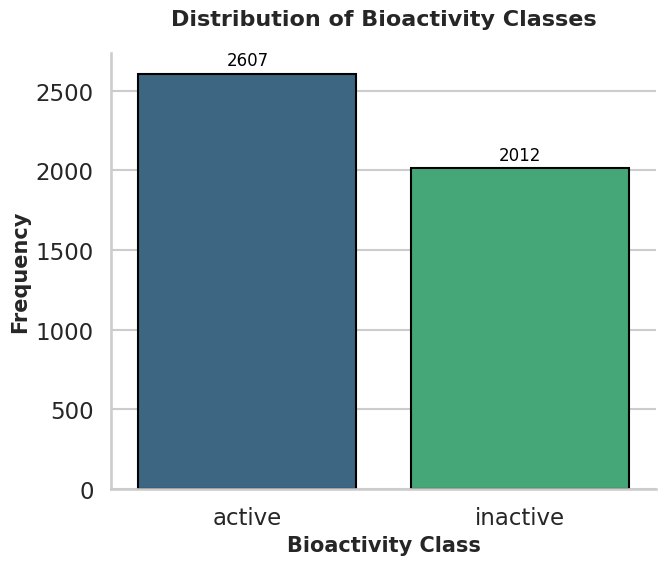

In [61]:
# Set the style and context of the plot
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the figure and axis objects
plt.figure(figsize=(7, 6))

# Create the countplot
ax = sns.countplot(x='class', data=df_2class, palette="viridis", edgecolor='black')

# Add title and modify labels
plt.title('Distribution of Bioactivity Classes', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Bioactivity Class', fontsize=15, fontweight='bold')
plt.ylabel('Frequency', fontsize=15, fontweight='bold')

# Display value counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

# Remove the top and right spines for cleaner look
sns.despine()

# Save the plot
plt.tight_layout()
plt.savefig('plot_bioactivity_class.pdf')
plt.show()

In [62]:
! mkdir /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [63]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/

total 92813
-rw------- 1 root root  4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv
drwx------ 2 root root     4096 Oct  2 09:12 data
drwx------ 2 root root     4096 Oct  2 09:13 images
-rw------- 1 root root 90040905 Oct  2 09:09 Miniconda3-py37_4.9.2-Linux-x86_64.sh


In [64]:
!cp /content/plot_bioactivity_class.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [65]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

total 15
-rw------- 1 root root 15217 Oct  2 09:14 plot_bioactivity_class.pdf


### 3.4.2 Scatter Plot<a id = 20></a>

#### 3.4.2.1 Descriptors vs $pIC_{50}$<a id = 21></a>

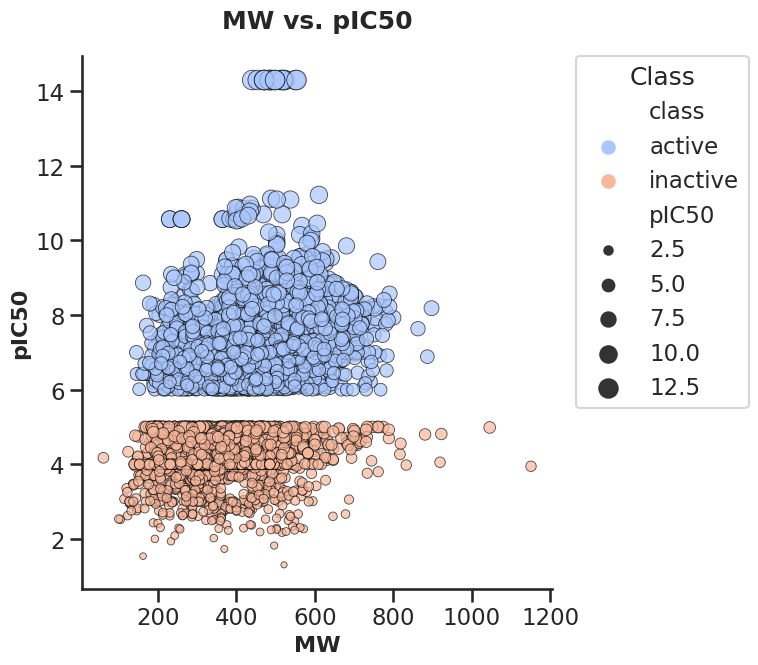

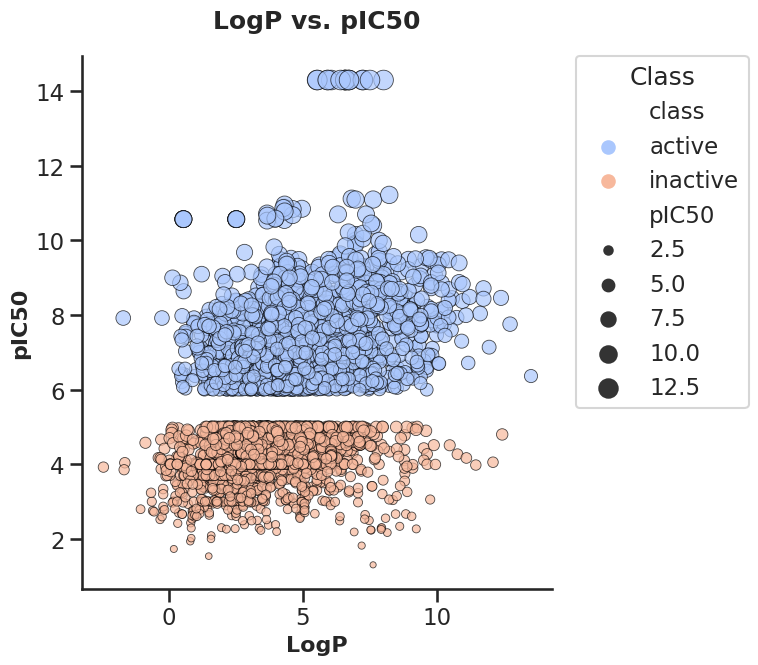

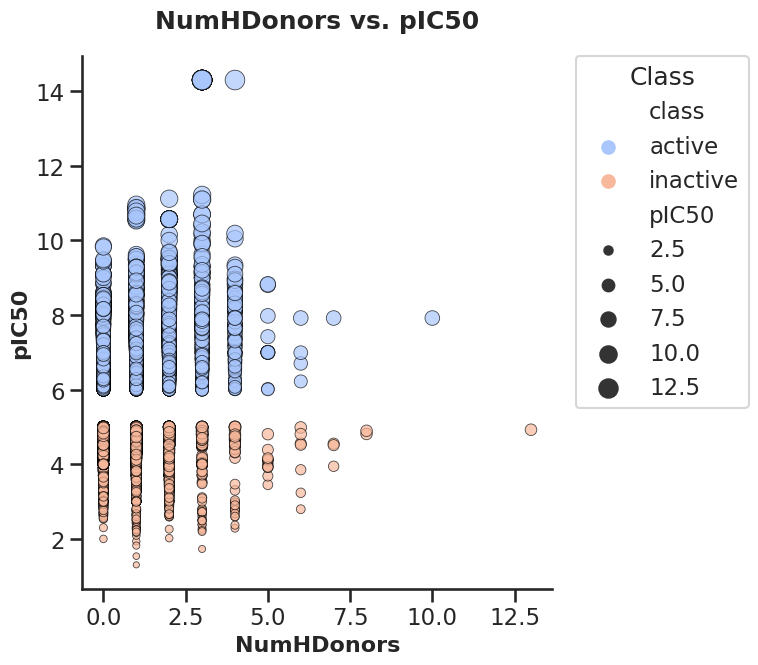

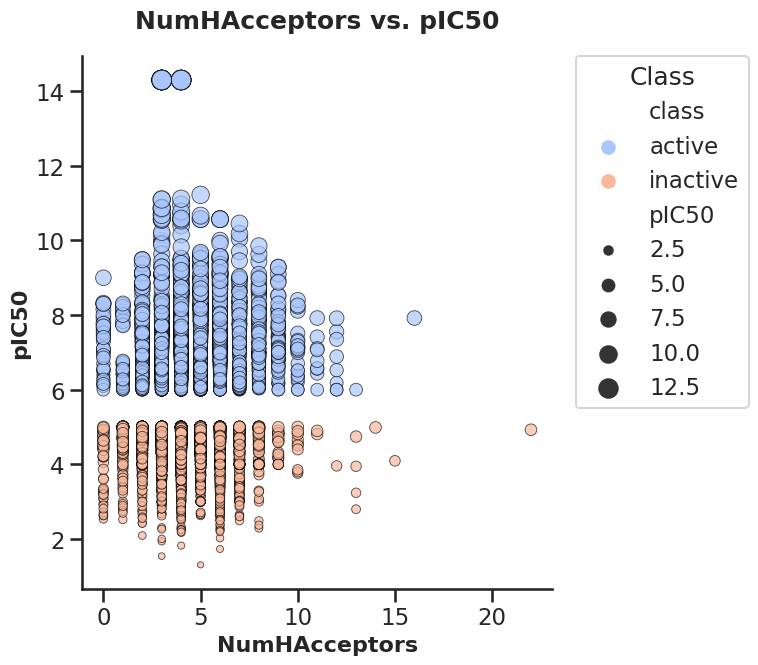

In [66]:
# List of descriptors
descriptors = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']

# Set the style and context of the plot
sns.set_style("ticks")
sns.set_context("talk")
palette = sns.color_palette("coolwarm", as_cmap=True)

# Loop through each descriptor and create a scatter plot
for descriptor in descriptors:
    plt.figure(figsize=(8, 7))

    sns.scatterplot(x=descriptor, y='pIC50', data=df_2class, hue='class', size='pIC50', sizes=(20, 200),
                    palette="coolwarm", edgecolor='black', alpha=0.7)

    plt.xlabel(descriptor, fontsize=16, fontweight='bold')
    plt.ylabel('pIC50', fontsize=16, fontweight='bold')
    plt.title(f'{descriptor} vs. pIC50', fontsize=18, fontweight='bold', pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Class')

    # Remove top and right spines for cleaner look
    sns.despine()

    # Save the plot
    plt.tight_layout()
    plt.savefig(f'plot_{descriptor}_vs_pIC50.pdf')
    plt.show()

In [67]:
! cp plot_LogP_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [68]:
! cp plot_MW_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [69]:
! cp plot_NumHAcceptors_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [70]:
! cp plot_NumHDonors_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [71]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

total 2898
-rw------- 1 root root  15217 Oct  2 09:14 plot_bioactivity_class.pdf
-rw------- 1 root root 784846 Oct  2 09:15 plot_LogP_vs_pIC50.pdf
-rw------- 1 root root 779657 Oct  2 09:15 plot_MW_vs_pIC50.pdf
-rw------- 1 root root 704462 Oct  2 09:15 plot_NumHAcceptors_vs_pIC50.pdf
-rw------- 1 root root 682323 Oct  2 09:15 plot_NumHDonors_vs_pIC50.pdf


**Analysis of Scatter Plots**

1. **Molecular Weight (MW) vs. $pIC_{50}$**
   - There's a broad distribution of molecular weights for both active and inactive compounds.
   - No distinct pattern emerges to suggest that molecular weight is directly correlated with bioactivity (measured by $pIC_{50}$).
   - However, there are a number of compounds with higher molecular weights (above ~500) that are predominantly inactive.

2. **LogP vs. $pIC_{50}$**
   - LogP represents the lipophilicity of a compound. Lipophilic compounds tend to have higher LogP values.
   - A majority of the active compounds seem to be concentrated around a LogP of 2 to 5, suggesting that there's an optimal lipophilicity range for activity against this target.
   - Extremely lipophilic compounds (with high LogP values) tend to be inactive.
   - But, again, there is not a clear pattern.

3. **Number of Hydrogen Donors vs. $pIC_{50}$**
   - Most of the active compounds have 0 to 2 hydrogen bond donors.

4.. **Number of Hydrogen Acceptors vs. $pIC_{50}$**
   - The data suggests that most of the active compounds have between 4 and 8 hydrogen bond acceptors.

**General Observations:**
- While there are patterns in the plots, these descriptors alone are not sufficient to predict bioactivity. The relationship between these descriptors and bioactivity is complex and likely influenced by other factors not captured in these descriptors.

#### 3.4.2.2 Descriptors<a id = 22></a>

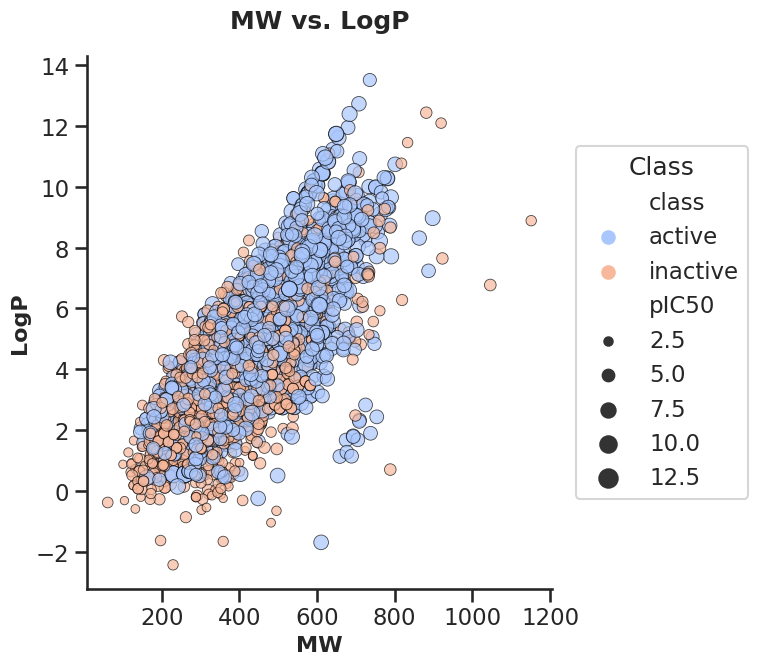

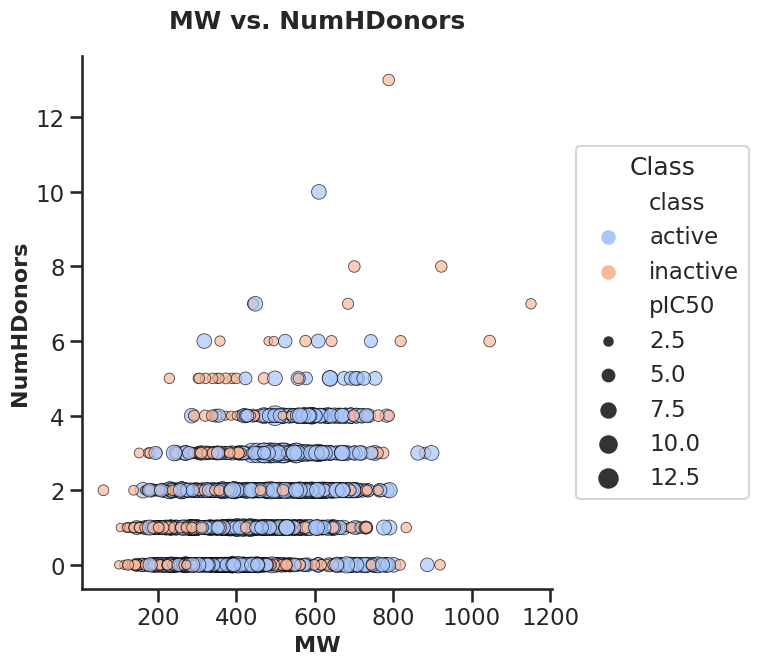

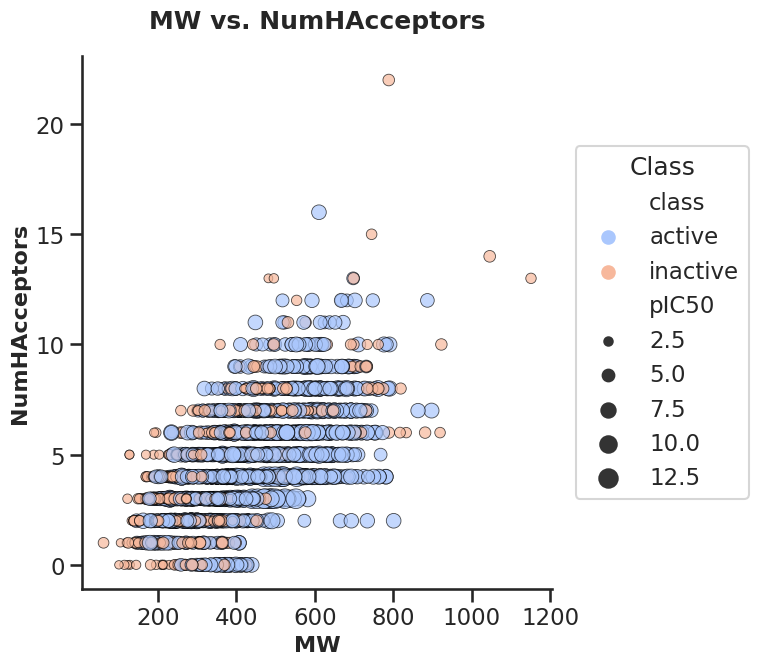

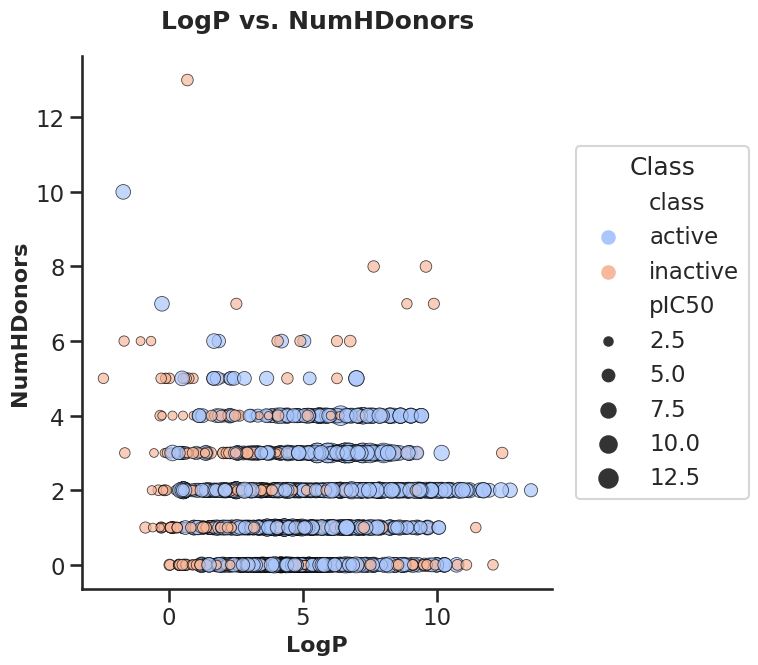

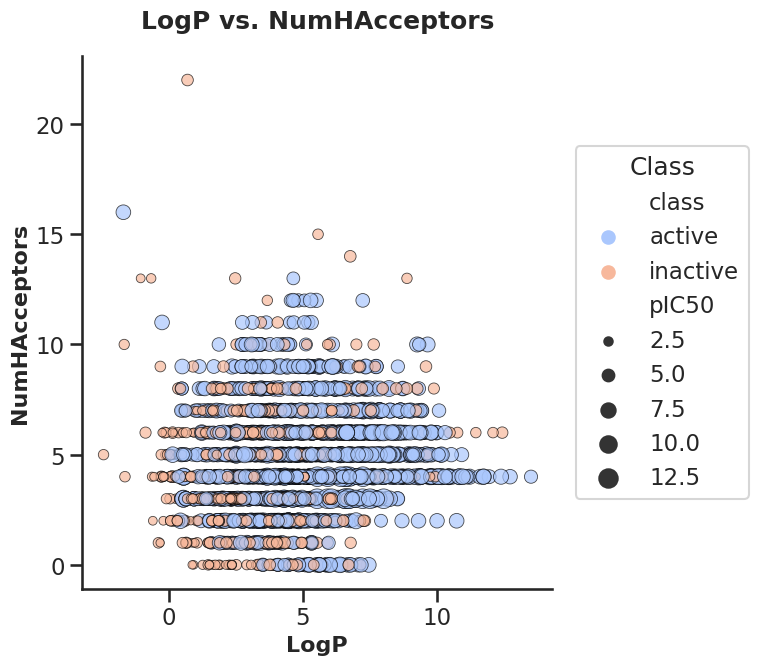

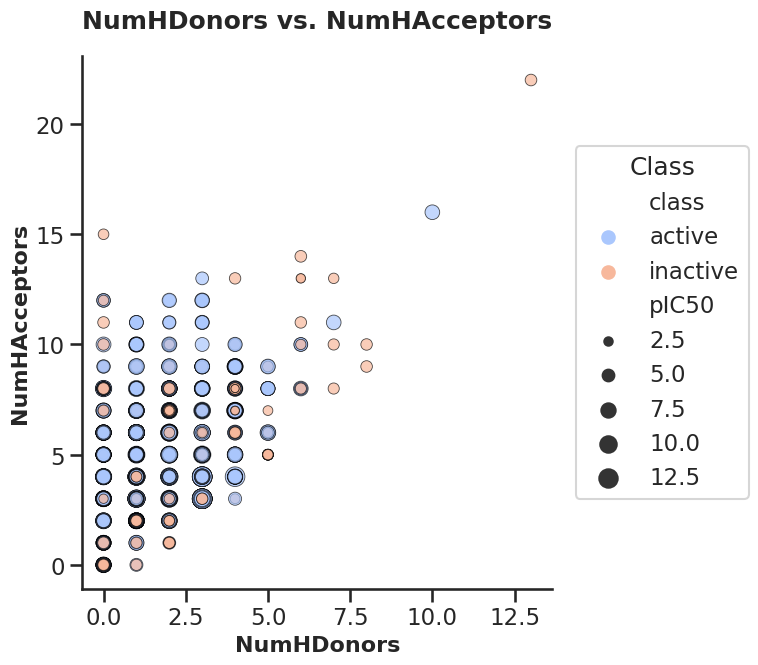

In [72]:
# List of descriptors
descriptors = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']

# Set the style and context of the plot for better aesthetics
sns.set_style("ticks")
sns.set_context("talk")
palette = sns.color_palette("coolwarm", as_cmap=True)

# Loop through each pair of descriptors and create a scatter plot
for i in range(len(descriptors)):
    for j in range(i+1, len(descriptors)):
        plt.figure(figsize=(8, 7))

        sns.scatterplot(x=descriptors[i], y=descriptors[j], data=df_2class, hue='class', size='pIC50', sizes=(20, 200),
                        palette="coolwarm", edgecolor='black', alpha=0.7)

        plt.xlabel(descriptors[i], fontsize=16, fontweight='bold')
        plt.ylabel(descriptors[j], fontsize=16, fontweight='bold')
        plt.title(f'{descriptors[i]} vs. {descriptors[j]}', fontsize=18, fontweight='bold', pad=20)

        # Position the legend outside the plot
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, title='Class')

        # Remove top and right spines for cleaner look
        sns.despine()

        # Save the plot
        plt.tight_layout()
        plt.savefig(f'plot_{descriptors[i]}_vs_{descriptors[j]}.pdf')
        plt.show()

In [74]:
! cp /content/plot_LogP_vs_NumHAcceptors.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [81]:
! cp /content/plot_LogP_vs_NumHDonors.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [82]:
! cp /content/plot_LogP_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [83]:
! cp /content/plot_MW_vs_LogP.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [84]:
! cp /content/plot_MW_vs_NumHAcceptors.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [85]:
! cp /content/plot_MW_vs_NumHDonors.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [86]:
! cp /content/plot_MW_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [87]:
! cp /content/plot_NumHAcceptors_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [88]:
! cp /content/plot_NumHDonors_vs_NumHAcceptors.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [89]:
! cp /content/plot_NumHDonors_vs_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

**Analysis of Pairwise Scatter Plots:**

1. **MW (Molecular Weight) vs. Other Descriptors:**
- **MW vs. LogP:** There is no clear trend between molecular weight and lipophilicity (LogP). Compounds of various molecular weights are scattered across different lipophilicity levels.
- **MW vs. NumHDonors:** The majority of compounds have low numbers of hydrogen donors, irrespective of their molecular weight.
- **MW vs. NumHAcceptors:** No evident trend can be discerned between molecular weight and the number of hydrogen acceptors.

2. **LogP (Lipophilicity) Relationships:**
- **LogP vs. NumHDonors:** Compounds with higher lipophilicity (LogP) generally have fewer hydrogen bond donors.
- **LogP vs. NumHAcceptors:** A moderate spread is observed, indicating no strong relationship between lipophilicity and the number of hydrogen bond acceptors.

3. **NumHDonors (Number of Hydrogen Donors) vs. NumHAcceptors:**
- A wide distribution is observed, indicating that the number of hydrogen donors in a compound does not necessarily dictate its number of hydrogen acceptors.

### 3.4.3 Pair Plot of Descriptors vs $pIC_{50}$<a id = 23></a>

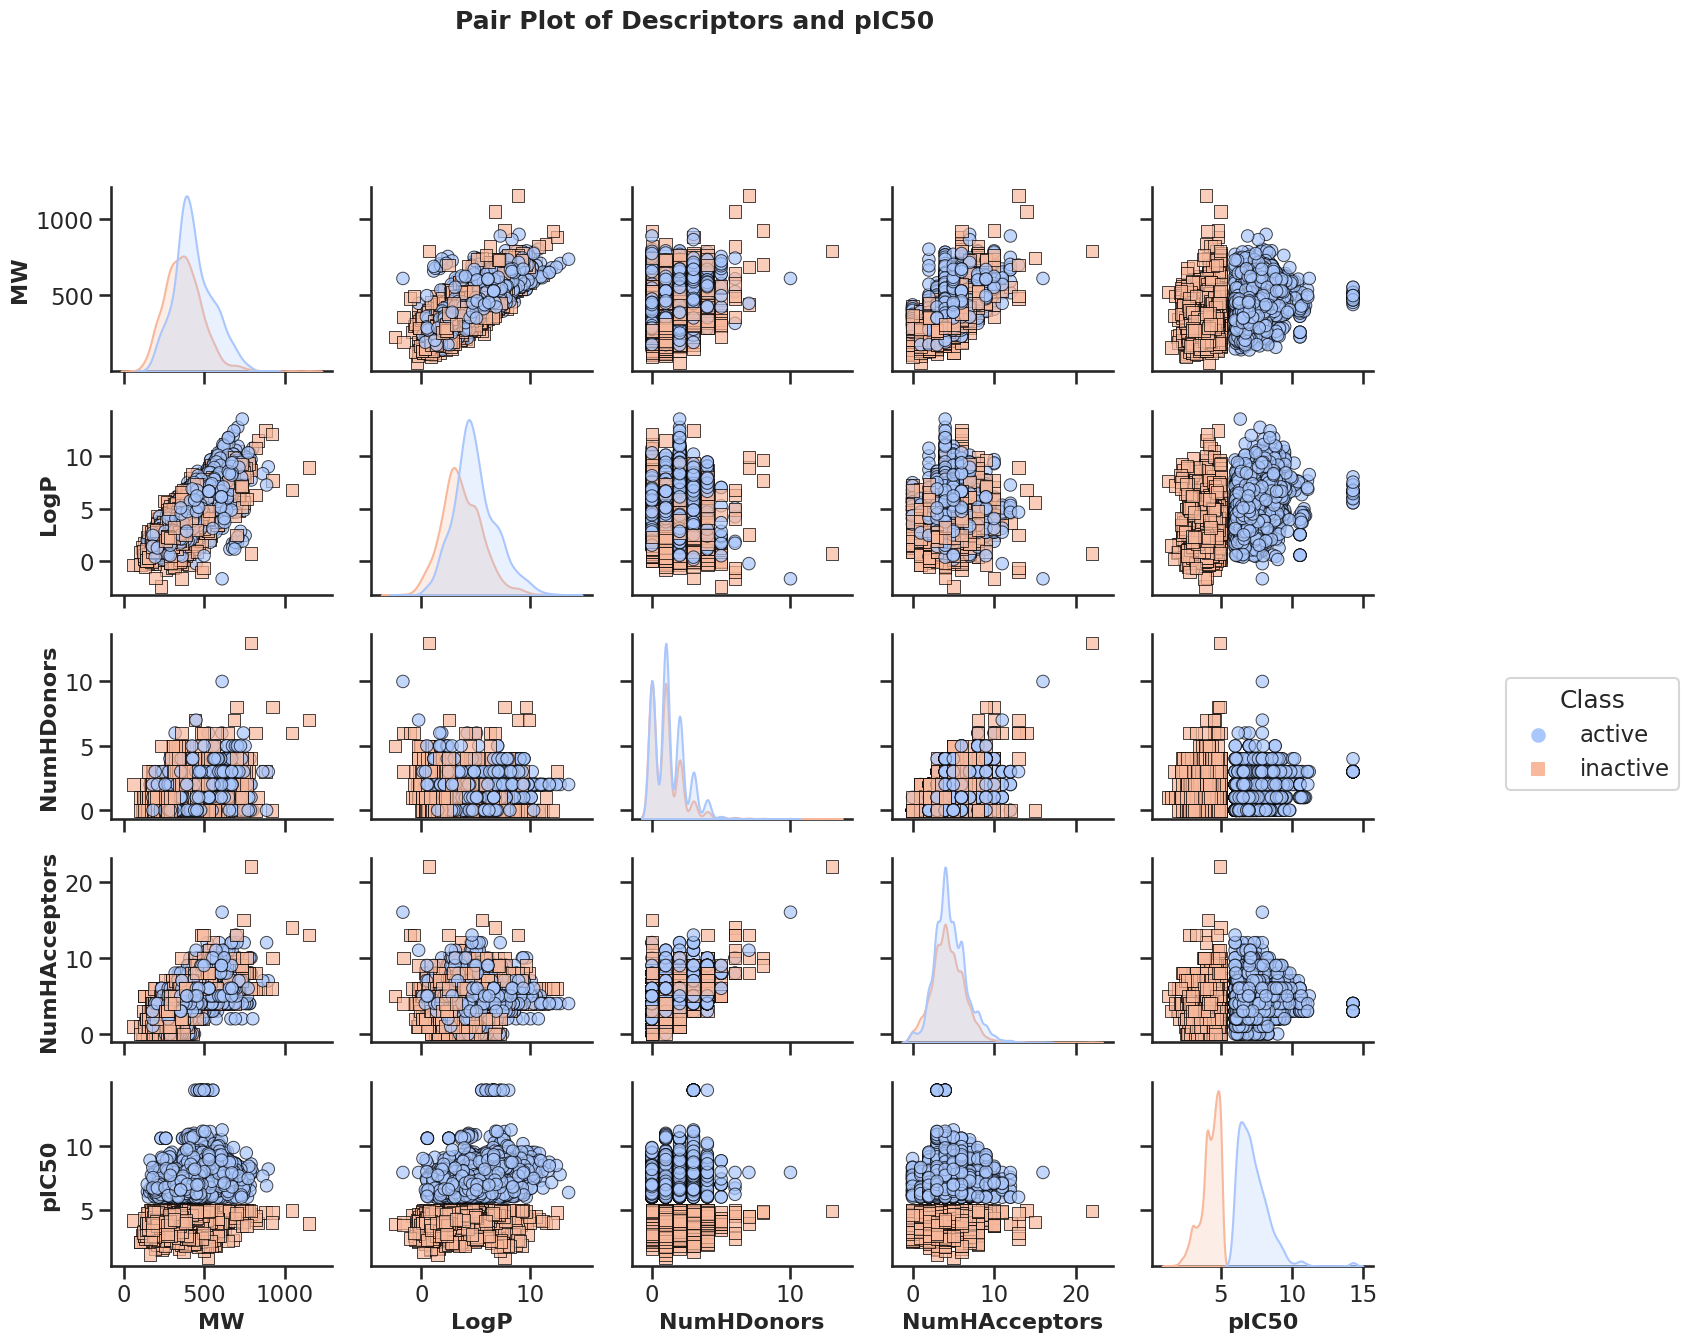

In [73]:
# Set the style and context of the plot
sns.set_style("ticks")
sns.set_context("talk")
palette = sns.color_palette("coolwarm", as_cmap=True)

# List of descriptors including pIC50
descriptors = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50']

# Create the pair plot
g = sns.pairplot(df_2class, x_vars=descriptors, y_vars=descriptors, hue='class',
                 palette="coolwarm", markers=["o", "s"], plot_kws={'alpha':0.7, 'edgecolor':'black'})

# Adjust the title and axis labels
g.fig.suptitle('Pair Plot of Descriptors and pIC50', y=1.08, fontsize=18, fontweight='bold')
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=16, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=16, fontweight='bold')

# Position the legend outside of the figure using bbox_to_anchor
# First, we'll remove the existing legend
g._legend.remove()

# Then, we'll add a new legend outside of the plot
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='center right', title='Class', bbox_to_anchor=(1.2, 0.5))

# Remove top and right spines for cleaner look
sns.despine()

# Save the plot
plt.tight_layout()
plt.savefig('pair_plot_descriptors_pIC50.pdf')
plt.show()


**Analysis of the Pair Plot:**

**General Observation:**
- The diagonal plots (histograms) give distributions of each descriptor and $pIC_{50}$ for both active and inactive compounds.

1. **MW (Molecular Weight) Relationships:**
- **MW vs. LogP:** There seems to be no clear trend between molecular weight and lipophilicity (LogP). Both active and inactive compounds span a wide range of molecular weights for any given LogP value.
- **MW vs. NumHDonors & NumHAcceptors:** No distinct pattern emerges suggesting a direct correlation between molecular weight and the number of hydrogen donors or acceptors.
- **MW vs. $pIC_{50}$:** As noted in the scatter plot analysis, there are a number of compounds with higher molecular weights that are predominantly inactive, especially those above ~500.

2. **LogP (Lipophilicity) Relationships:**
- **LogP vs. NumHDonors:** There's a noticeable trend where compounds with higher lipophilicity (LogP) generally have fewer hydrogen bond donors.
- **LogP vs. NumHAcceptors:** No strong trend emerges, though there is a slight increase in the number of hydrogen bond acceptors for compounds with higher lipophilicity.
- **LogP vs. $pIC_{50}$:** Active compounds tend to be concentrated around a LogP of 2 to 5, suggesting an optimal lipophilicity range for activity against this target.

3. **NumHDonors (Number of Hydrogen Donors) Relationships:**
- **NumHDonors vs. NumHAcceptors:** No strong correlation can be discerned between the number of hydrogen donors and acceptors.
- **NumHDonors vs. $pIC_{50}$:** Most active compounds have 0 to 2 hydrogen bond donors. As the number increases, the compounds tend to be more inactive.

4. **NumHAcceptors (Number of Hydrogen Acceptors) Relationships:**
- **NumHAcceptors vs. $pIC_{50}$:** Most of the active compounds seem to have between 4 and 8 hydrogen bond acceptors.

In [90]:
! cp pair_plot_descriptors_pIC50.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

### 3.4.4 Box Plot of Descriptors<a id = 24></a>

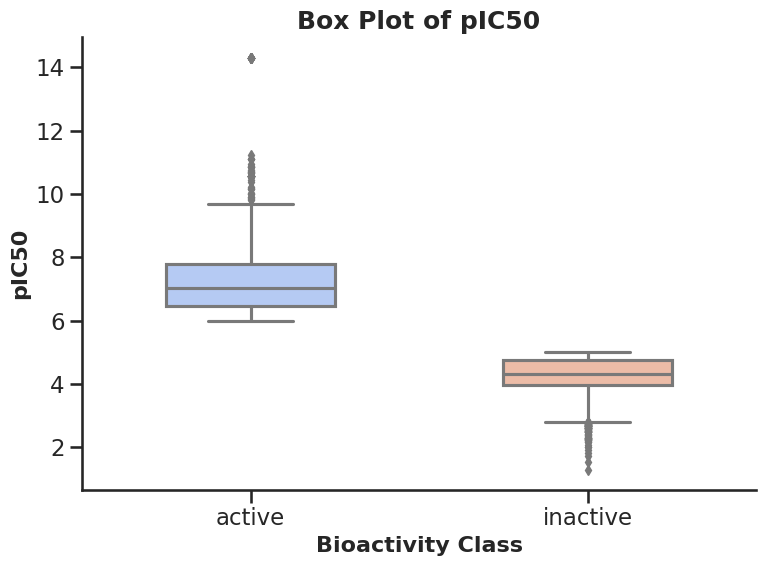

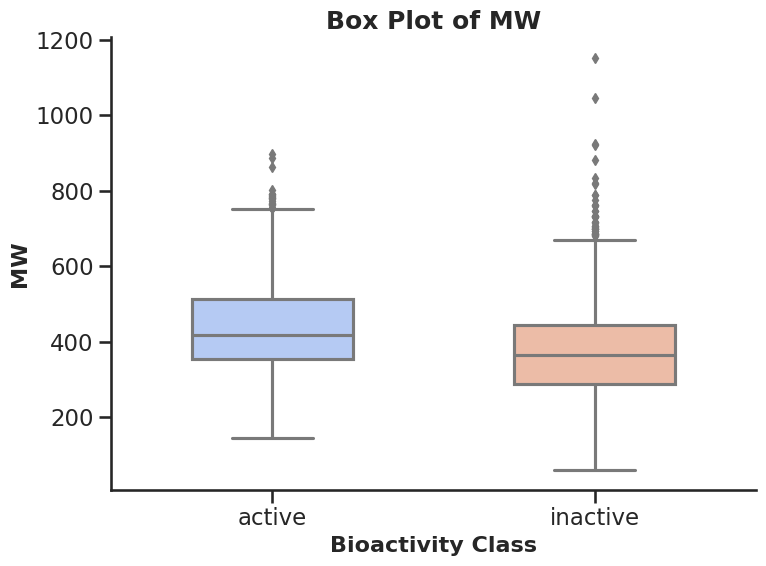

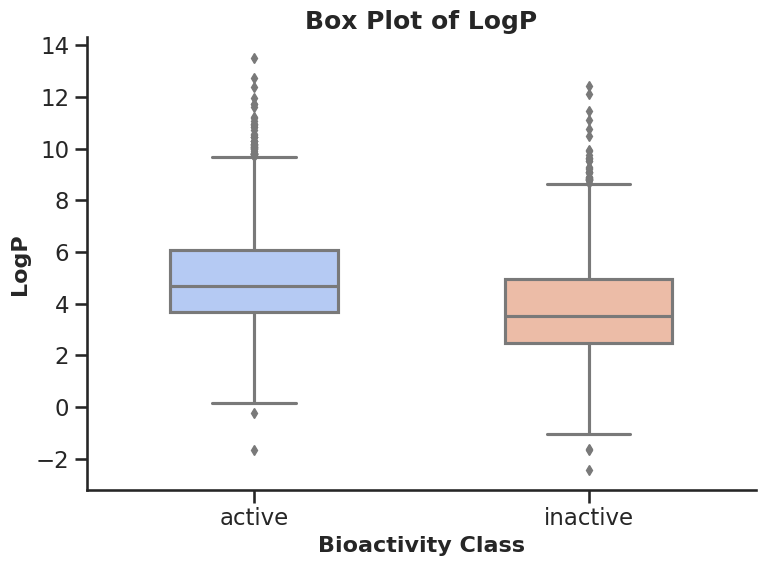

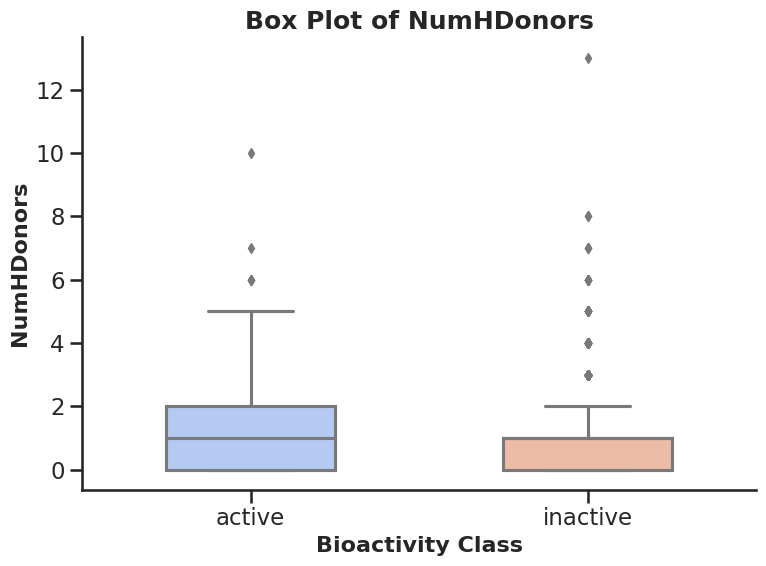

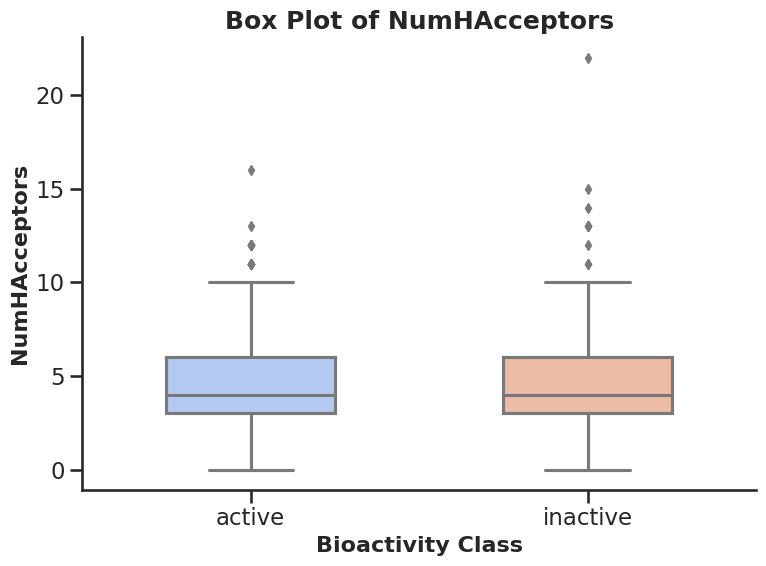

In [91]:
# Set the style and context of the plot
sns.set_style("ticks")
sns.set_context("talk")

# List of descriptors
descriptors = ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']

# Create box plots for each descriptor
for descriptor in descriptors:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='class', y=descriptor, data=df_2class, palette="coolwarm", width=0.5)

    # Adjust the title and axis labels
    plt.title(f'Box Plot of {descriptor}', fontsize=18, fontweight='bold')
    plt.xlabel('Bioactivity Class', fontsize=16, fontweight='bold')
    plt.ylabel(descriptor, fontsize=16, fontweight='bold')

    # Remove top and right spines for cleaner look
    sns.despine()

    # Save the plot
    plt.tight_layout()
    plt.savefig(f'box_plot_{descriptor}.pdf')
    plt.show()

In [92]:
! cp /content/box_plot_* /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

**Analysis of Box Plots:**

1. **pIC50:**
- The pIC50 values for active compounds are noticeably higher than for inactive ones. This is expected since a higher pIC50 value indicates stronger binding affinity.

2. **MW (Molecular Weight):**
- Both active and inactive classes have a similar interquartile range, but inactive compounds tend to have a slightly higher median molecular weight.

3. **LogP (Lipophilicity):**
- Active compounds exhibit a higher median LogP value, indicating that lipophilic compounds are generally more active. There’s also a broader distribution of LogP values in the active class.

4. **NumHDonors (Number of Hydrogen Donors):**
- The number of hydrogen donors is relatively low for both classes, with inactive compounds showing a slightly higher median. The boxplot for inactive compounds is more compressed, indicating less variability in the data.

5. **NumHAcceptors (Number of Hydrogen Acceptors):**
- Active and inactive compounds exhibit similar distributions for the number of hydrogen acceptors, although active compounds have a slightly lower median.

## 3.5 Statistical Analysis | Mann-Whitney U Test<a id = 25></a>

The Mann-Whitney U test<sup><a href="#ref9">[9]</a></sup> , also known as the Wilcoxon rank-sum test, is a non-parametric test that is used to compare two independent samples to determine if they come from the same distribution. It's particularly useful when the data doesn't meet the assumptions of a t-test (e.g., when data isn't normally distributed or when variances aren't equal).

In the context of drug discovery, the Mann-Whitney U test can be used to compare the distributions of molecular properties (like molecular weight, LogP, etc.) between two groups of compounds, such as active vs. inactive compounds. This can help in understanding if certain properties are statistically different between the two groups, which can provide insights into the characteristics of active compounds.

### Importance in Drug Discovery:

1. **Identifying Key Properties**: By comparing the distributions of properties between active and inactive compounds, researchers can identify which properties are crucial for activity. This can guide the design of new compounds.
2. **Filtering Compounds**: If certain properties are found to be statistically different between active and inactive compounds, this information can be used to filter and prioritize compounds in a screening library.
3. **Guiding Further Experiments**: The results of the Mann-Whitney U test can provide insights that guide further experimental work, such as synthesis of new compounds or modification of existing ones.
4. **Non-parametric Analysis**: Since the Mann-Whitney U test doesn't assume a normal distribution, it's particularly useful in drug discovery where data distributions can often be skewed or have outliers.

In [93]:
def mannwhitney(descriptor, verbose=False):
    """
    Perform the Mann-Whitney U Test between active and inactive molecules for a given descriptor.

    This function takes a descriptor (e.g., 'MW', 'LogP') and compares the distributions of this descriptor
    between active and inactive molecules using the Mann-Whitney U Test. The test determines if the two
    samples (active and inactive molecules) are drawn from the same distribution.

    Parameters:
    - descriptor (str): The descriptor for which the Mann-Whitney U Test should be performed.
    - verbose (bool, optional): If True, prints additional information. Default is False.

    Returns:
    - pd.DataFrame: A DataFrame containing the test results, including the test statistic, p-value,
                    significance level (alpha), and interpretation of the result.

    Notes:
    The function also saves the test results to a CSV file named 'mannwhitneyu_<descriptor>.csv'.

    References:
    - https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

    Example:
    >>> mannwhitney('MW')
       Descriptor  Statistics         p  alpha              Interpretation
    0          MW        ...       ...    0.05  Different distribution (reject H0)
    """
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    # seed the random number generator
    seed(1)

    # actives and inactives
    selection = [descriptor, 'class']
    df = df_2class[selection]
    active = df[df['class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'class']
    df = df_2class[selection]
    inactive = df[df['class'] == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

### 3.5.1 pIC50<a id = 27></a>

In [94]:
mannwhitney('pIC50')

Descriptor  Statistics    p  alpha                      Interpretation
0      pIC50   5245284.0  0.0   0.05  Different distribution (reject H0)

### 3.5.2 Molecular Weight (MW)<a id = 27></a>

In [95]:
mannwhitney('MW')

Descriptor  Statistics             p  alpha  \
0         MW   3400942.0  3.360573e-67   0.05   

                       Interpretation  
0  Different distribution (reject H0)

### 3.5.3 Octanol-Water Partition Coefficient (LogP)<a id = 28></a>

In [96]:
mannwhitney('LogP')

Descriptor  Statistics             p  alpha  \
0       LogP   3529059.5  1.784123e-90   0.05   

                       Interpretation  
0  Different distribution (reject H0)

### 3.5.4 Number of Hydron Donors (NumHDonors)<a id = 29></a>


In [97]:
mannwhitney('NumHDonors')

Descriptor  Statistics             p  alpha  \
0  NumHDonors   3002935.0  6.724468e-19   0.05   

                       Interpretation  
0  Different distribution (reject H0)

### 3.5.4 Number of Hydron Acceptor (NumHAcceptor)<a id = 30></a>

In [98]:
mannwhitney('NumHAcceptors')

Descriptor  Statistics         p  alpha  \
0  NumHAcceptors   2824753.5  0.000005   0.05   

                       Interpretation  
0  Different distribution (reject H0)

### 3.5.5 Interpretation of the Statistical Results<a id = 31></a>

1. **pIC50**:
- **Statistics (U-statistic):** 5,245,284.0
- **p-value:** 0.0
- **Interpretation:** The two groups (active and inactive compounds) have significantly different distributions for the $pIC_{50}$ values. This outcome is anticipated since $pIC_{50}$ directly correlates with bioactivity.

2. **MW (Molecular Weight)**:
- **Statistics (U-statistic):** 3,400,942.0
- **p-value:** $ 3.36 \times 10^{-67} $
- **Interpretation:** The molecular weights of active and inactive compounds are drawn from different distributions. The very small p-value indicates a strong statistical difference between the two groups.

3. **LogP (Lipophilicity)**:
- **Statistics (U-statistic):** 3,529,059.5
- **p-value:** $ 1.78 \times 10^{-90} $
- **Interpretation:** There is a significant difference in the lipophilicity (LogP) distributions of active and inactive compounds. The extremely small p-value emphasizes the significance of this difference.

4. **NumHDonors (Number of Hydrogen Donors)**:
- **Statistics (U-statistic):** 3,002,935.0
- **p-value:** $ 6.72 \times 10^{-19} $
- **Interpretation:** The number of hydrogen donors also varies significantly between the two bioactivity classes, with a strong statistical difference evident from the p-value.

5. **NumHAcceptors (Number of Hydrogen Acceptors)**:
- **Statistics (U-statistic):** 2,824,753.5
- **p-value:** 0.000005 (or $ 5 \times 10^{-6} $)
- **Interpretation:** The number of hydrogen acceptors shows a significant difference between active and inactive compounds, as indicated by the low p-value.

**Summary:**
All descriptors, display significantly different distributions between active and inactive compounds. The extremely low p-values for all descriptors emphasize the statistical significance of these differences. This suggests that each of these descriptors could potentially play a role in determining the bioactivity of the compounds.


In [99]:
! cp /content/mannwhitneyu_* /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

In [100]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

total 7268
-rw------- 1 root root  633270 Oct  2 09:12 acetylcholinesterase_bioactivity_data_2class_pIC50.csv
-rw------- 1 root root  853788 Oct  2 09:12 acetylcholinesterase_bioactivity_data_3class_pIC50.csv
-rw------- 1 root root  508567 Oct  2 09:08 acetylcholinesterase_bioactivity_data_class.csv
-rw------- 1 root root  452267 Oct  2 09:06 acetylcholinesterase_bioactivity_data_preprocessed.csv
-rw------- 1 root root 4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv
-rw------- 1 root root     125 Oct  2 09:23 mannwhitneyu_LogP.csv
-rw------- 1 root root     123 Oct  2 09:23 mannwhitneyu_MW.csv
-rw------- 1 root root     132 Oct  2 09:23 mannwhitneyu_NumHAcceptors.csv
-rw------- 1 root root     131 Oct  2 09:23 mannwhitneyu_NumHDonors.csv
-rw------- 1 root root     108 Oct  2 09:23 mannwhitneyu_pIC50.csv


## 3.6 PaDEL Descriptors<a id = 32></a>

**PaDEL-Descriptor**<sup><a href="#ref10">[10]</a></sup>  is a software application designed to calculate molecular descriptors and fingerprints. These descriptors and fingerprints are essential in cheminformatics for the representation of molecular structures in computational models, especially in the context of drug design and predictive modeling.

The software can compute a total of 1,486 descriptors (1,444 chemical descriptors and 42 types of fingerprints). These descriptors encompass a wide range of properties, including topological, geometrical, constitutional, electronic, and hybrid descriptors. The fingerprints can be used for similarity searching, virtual screening, and other applications where molecular similarity is of interest.

The generated fingerprints enable the rapid comparison of extensive molecule sets, serving various tasks such as virtual screening, similarity searching, or constructing machine learning models in chemoinformatics.

**Main Applications:**

1. **Drug Design:** PaDEL-Descriptor can be used in the drug design process to calculate molecular descriptors that can be input into computational models to predict drug properties, activities, and toxicities.
2. **Predictive Modeling:** In cheminformatics, predictive modeling often requires a set of descriptors to represent molecular structures. PaDEL-Descriptor provides a comprehensive set of these descriptors.
3. **Virtual Screening:** The fingerprints generated by PaDEL-Descriptor can be used in virtual screening campaigns to identify molecules that are similar to known active compounds.
4. **Similarity Searching:** The molecular fingerprints can be used to search large databases for molecules that are similar to a query molecule.

**How does it work?**

1. **Input**
- PaDEL can process various compound input formats, such as SDF (Structure-Data File) or SMILES strings.

2. **Molecular Representation**
- The software initially deciphers the molecular structures from the input. For each molecule, an internal data structure is created, signifying atoms, bonds, and other molecular elements.

3. **Descriptor Calculation**
- PaDEL is adept at computing an extensive variety of molecular descriptors. These are numerical or boolean (0/1) values denoting diverse molecular attributes and features. Descriptors can encapsulate details like molecular weight, bond types count, topological attributes, among others.

4. **Fingerprint Calculation**
- Apart from descriptors, PaDEL can compute different molecular fingerprint types:
   - **Substructure Fingerprints**: These fingerprints are contingent on the presence or absence of distinct substructures or patterns in the molecule. If a molecule embodies a specific functional group, a corresponding bit in the fingerprint is set to 1; if not, it's 0.
   - **Path-based Fingerprints**: These represent varying paths of interconnected atoms in the molecule.
   - **Circular Fingerprints (e.g., Morgan Fingerprints)**: Generated by assessing the atom environment in progressive circular layers.

5. **Output**
- Post-calculation, the software provides the descriptors and fingerprints in a designated format, usually CSV. Each row corresponds to a molecule, while each column matches a descriptor or a fingerprint's bit position.

6. **Configuration**
- PaDEL offers extensive configurability. Users can dictate the types of descriptors or fingerprints they wish to compute through XML configuration files. Additionally, certain preprocessing operations, like salt removal from structures, can be applied.

7. **Integration with Java**
- At its core, PaDEL is developed in Java and utilizes the Chemistry Development Kit (CDK), an open-source Java library tailored for structural chemo- and bioinformatics.

Source: http://www.yapcwsoft.com/dd/padeldescriptor/

### 3.6.1 Download PaDEL-Descriptor<a id = 33></a>

The PaDEL was downloaded directly from the github of **dataprofessor**, whom developed a practical way to use it together in google colab.

In [108]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! unzip padel.zip

--2023-10-02 09:28:26--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-10-02 09:28:26--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.1s    

2023-10-02 09:28:27 (245 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2023-10-02 09:28:27--  https://gi

In [109]:
! cp /content/padel* /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016

### 3.6.2 Loading the Bioactivity Data<a id = 34></a>

In [101]:
df6 = pd.read_csv("/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_3class_pIC50.csv")

In [102]:
df6

Unnamed: 0 molecule_chembl_id  \
0              0       CHEMBL133897   
1              1       CHEMBL336398   
2              2       CHEMBL131588   
3              3       CHEMBL130628   
4              4       CHEMBL130478   
...          ...                ...   
6151        6152      CHEMBL5219841   
6152        6153      CHEMBL5219046   
6153        6154      CHEMBL5219594   
6154        6155      CHEMBL5219958   
6155        6156      CHEMBL5220884   

                                       canonical_smiles         class  \
0                 CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1        active   
1            O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1        active   
2     CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1      inactive   
3         O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F        active   
4             CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C        active   
...                                                 ...           ...   
6151         COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1        active   
6152      CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1        active   
6153             O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1      inactive   
6154         CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1      inactive   
6155  Cn1ccc2cc(-c3cnc4ccc(C(=O)N5CCCCC5)cc4n3)ccc2c1=O  intermediate   

           MW    LogP  NumHDonors  NumHAcceptors     pIC50  
0     312.325  2.8032         0.0            6.0  6.124939  
1     376.913  4.5546         0.0            5.0  7.000000  
2     426.851  5.3574         0.0            5.0  4.301030  
3     404.845  4.7069         0.0            5.0  6.522879  
4     346.334  3.0953         0.0            6.0  6.096910  
...       ...     ...         ...            ...       ...  
6151  390.461  2.8334         2.0            5.0  9.679854  
6152  352.478  5.0610         1.0            3.0  6.562249  
6153  287.246  2.1994         1.0            4.0  4.118045  
6154  311.337  3.1837         1.0            4.0  4.259637  
6155  398.466  3.7748         0.0            5.0  5.267606  

[6156 rows x 9 columns]

In [103]:
selection = ['canonical_smiles','molecule_chembl_id']
df6_selection = df6[selection]
df6_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [104]:
! cp /content/molecule.smi /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

In [105]:
! cat /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/molecule.smi | head -5

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C	CHEMBL130478


In [107]:
! cat /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/molecule.smi | wc -l

6156


### 3.6.3 Calculate fingerprint descriptors<a id = 35></a>

In [112]:
! cat /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv



1. **`java`**: Initiates the Java runtime environment, indicating the start of a Java application execution.

2. **`-Xms1G -Xmx1G`**:
   - `-Xms1G`: Sets the initial heap size for the Java Virtual Machine (JVM) to 1 gigabyte.
   - `-Xmx1G`: Sets the maximum heap size for the JVM to 1 gigabyte. This limits PaDEL's memory usage to 1 GB.

3. **`-Djava.awt.headless=true`**: Runs the Java AWT (Abstract Window Toolkit) in "headless" mode, i.e., without a GUI. Useful for server environments or other non-GUI contexts.

4. **`-jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar`**: Specifies the JAR (Java Archive) file to be executed, located at `./PaDEL-Descriptor/PaDEL-Descriptor.jar`.

5. **`-removesalt`**: Instructs PaDEL to remove salt components from molecules before computing descriptors.

6. **`-standardizenitro`**: Directs PaDEL to standardize the representation of nitro groups in molecules.

7. **`-fingerprints`**: Commands PaDEL to compute molecular fingerprints.

8. **`-descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml`**: Designates the type of descriptors to compute, as defined in the `PubchemFingerprinter.xml` file.

9. **`-dir ./`**: Specifies the directory containing the input molecule files (usually in SDF format). Here, `./` denotes the current directory.

10. **`-file descriptors_output.csv`**: Names the output file where PaDEL will save the computed descriptors, in this case, as `descriptors_output.csv`.


In [167]:
!chmod +r /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase/acetylcholinesterase_project/Project/padel/PaDEL-Descriptor/PubchemFingerprinter.xml

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected


In [65]:
! bash /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase/acetylcholinesterase_project/Project/padel/padel.sh

Streaming output truncated to the last 5000 lines.
Processing CHEMBL190322 in Copia de molecule.smi (989/6156). Average speed: 1.24 s/mol.
Processing CHEMBL371787 in Copia de molecule.smi (990/6156). Average speed: 1.25 s/mol.
Processing CHEMBL363557 in Copia de molecule.smi (993/6156). Average speed: 1.25 s/mol.
Processing CHEMBL191416 in Copia de molecule.smi (995/6156). Average speed: 1.25 s/mol.
Processing CHEMBL191386 in Copia de molecule.smi (997/6156). Average speed: 1.25 s/mol.
Processing CHEMBL364545 in Copia de molecule.smi (999/6156). Average speed: 1.25 s/mol.
Processing CHEMBL191314 in Copia de molecule.smi (1001/6156). Average speed: 1.25 s/mol.
Processing CHEMBL372710 in Copia de molecule.smi (1003/6156). Average speed: 1.25 s/mol.
Processing CHEMBL191461 in Copia de molecule.smi (1005/6156). Average speed: 1.25 s/mol.
Processing CHEMBL365136 in Copia de molecule.smi (1007/6156). Average speed: 1.25 s/mol.
Processing CHEMBL189797 in Copia de molecule.smi (1009/6156). Ave

In [113]:
! cp /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase/acetylcholinesterase_project/Project/data/descriptors_output.csv /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

In [114]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

total 18359
-rw------- 1 root root   633270 Oct  2 09:12 acetylcholinesterase_bioactivity_data_2class_pIC50.csv
-rw------- 1 root root   853788 Oct  2 09:12 acetylcholinesterase_bioactivity_data_3class_pIC50.csv
-rw------- 1 root root   508567 Oct  2 09:08 acetylcholinesterase_bioactivity_data_class.csv
-rw------- 1 root root   452267 Oct  2 09:06 acetylcholinesterase_bioactivity_data_preprocessed.csv
-rw------- 1 root root  4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv
-rw------- 1 root root 10954293 Oct  2 09:35 descriptors_output.csv
-rw------- 1 root root      125 Oct  2 09:23 mannwhitneyu_LogP.csv
-rw------- 1 root root      123 Oct  2 09:23 mannwhitneyu_MW.csv
-rw------- 1 root root      132 Oct  2 09:23 mannwhitneyu_NumHAcceptors.csv
-rw------- 1 root root      131 Oct  2 09:23 mannwhitneyu_NumHDonors.csv
-rw------- 1 root root      108 Oct  2 09:23 mannwhitneyu_pIC50.csv
-rw------- 1 root root   401845 Oct  2 09:25 molecule.smi


### 3.6.4 Preparing the X and Y Matrices<a id = 36></a>

#### 3.6.4.1 X-Matrix<a id = 37></a>

In [115]:
df6_descriptors = pd.read_csv('/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase/acetylcholinesterase_project/Project/data/descriptors_output.csv')

In [116]:
df6_descriptors

Name  PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  \
0      CHEMBL133897           1           1           1           0   
1      CHEMBL336398           1           1           1           0   
2      CHEMBL131588           1           1           0           0   
3      CHEMBL130628           1           1           1           0   
4      CHEMBL130478           1           1           0           0   
...             ...         ...         ...         ...         ...   
6151  CHEMBL5219841           1           1           1           0   
6152  CHEMBL5219594           1           1           0           0   
6153  CHEMBL5219046           1           1           1           0   
6154  CHEMBL5219958           1           1           1           0   
6155  CHEMBL5220884           1           1           1           0   

      PubchemFP4  PubchemFP5  PubchemFP6  PubchemFP7  PubchemFP8  ...  \
0              0           0           0           0           0  ...   
1              0           0           0           0           0  ...   
2              0           0           0           0           0  ...   
3              0           0           0           0           0  ...   
4              0           0           0           0           0  ...   
...          ...         ...         ...         ...         ...  ...   
6151           0           0           0           0           0  ...   
6152           0           0           0           0           0  ...   
6153           0           0           0           0           0  ...   
6154           0           0           0           0           0  ...   
6155           0           0           0           0           0  ...   

      PubchemFP871  PubchemFP872  PubchemFP873  PubchemFP874  PubchemFP875  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
6151             0             0             0             0             0   
6152             0             0             0             0             0   
6153             0             0             0             0             0   
6154             0             0             0             0             0   
6155             0             0             0             0             0   

      PubchemFP876  PubchemFP877  PubchemFP878  PubchemFP879  PubchemFP880  
0                0             0             0             0             0  
1                0             0             0             0             0  
2                0             0             0             0             0  
3                0             0             0             0             0  
4                0             0             0             0             0  
...            ...           ...           ...           ...           ...  
6151             0             0             0             0             0  
6152             0             0             0             0             0  
6153             0             0             0             0             0  
6154             0             0             0             0             0  
6155             0             0             0             0             0  

[6156 rows x 882 columns]

In [117]:
df6_X = df6_descriptors.drop(columns = ["Name"])
df6_X

PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0              1           1           1           0           0           0   
1              1           1           1           0           0           0   
2              1           1           0           0           0           0   
3              1           1           1           0           0           0   
4              1           1           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
6151           1           1           1           0           0           0   
6152           1           1           0           0           0           0   
6153           1           1           1           0           0           0   
6154           1           1           1           0           0           0   
6155           1           1           1           0           0           0   

      PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9  ...  PubchemFP871  \
0              0           0           0           1  ...             0   
1              0           0           0           1  ...             0   
2              0           0           0           1  ...             0   
3              0           0           0           1  ...             0   
4              0           0           0           1  ...             0   
...          ...         ...         ...         ...  ...           ...   
6151           0           0           0           1  ...             0   
6152           0           0           0           1  ...             0   
6153           0           0           0           1  ...             0   
6154           0           0           0           1  ...             0   
6155           0           0           0           1  ...             0   

      PubchemFP872  PubchemFP873  PubchemFP874  PubchemFP875  PubchemFP876  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
6151             0             0             0             0             0   
6152             0             0             0             0             0   
6153             0             0             0             0             0   
6154             0             0             0             0             0   
6155             0             0             0             0             0   

      PubchemFP877  PubchemFP878  PubchemFP879  PubchemFP880  
0                0             0             0             0  
1                0             0             0             0  
2                0             0             0             0  
3                0             0             0             0  
4                0             0             0             0  
...            ...           ...           ...           ...  
6151             0             0             0             0  
6152             0             0             0             0  
6153             0             0             0             0  
6154             0             0             0             0  
6155             0             0             0             0  

[6156 rows x 881 columns]

#### 3.6.4.2 Y-Variable<a id = 38></a>

In [118]:
df6_Y = df6['pIC50']
df6_Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
6151    9.679854
6152    6.562249
6153    4.118045
6154    4.259637
6155    5.267606
Name: pIC50, Length: 6156, dtype: float64

#### 3.6.4.3 Combining X and Y Variables<a id = 39></a>

In [119]:
dataset6 = pd.concat([df6_X,df6_Y], axis=1)
dataset6

PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0              1           1           1           0           0           0   
1              1           1           1           0           0           0   
2              1           1           0           0           0           0   
3              1           1           1           0           0           0   
4              1           1           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
6151           1           1           1           0           0           0   
6152           1           1           0           0           0           0   
6153           1           1           1           0           0           0   
6154           1           1           1           0           0           0   
6155           1           1           1           0           0           0   

      PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9  ...  PubchemFP872  \
0              0           0           0           1  ...             0   
1              0           0           0           1  ...             0   
2              0           0           0           1  ...             0   
3              0           0           0           1  ...             0   
4              0           0           0           1  ...             0   
...          ...         ...         ...         ...  ...           ...   
6151           0           0           0           1  ...             0   
6152           0           0           0           1  ...             0   
6153           0           0           0           1  ...             0   
6154           0           0           0           1  ...             0   
6155           0           0           0           1  ...             0   

      PubchemFP873  PubchemFP874  PubchemFP875  PubchemFP876  PubchemFP877  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
6151             0             0             0             0             0   
6152             0             0             0             0             0   
6153             0             0             0             0             0   
6154             0             0             0             0             0   
6155             0             0             0             0             0   

      PubchemFP878  PubchemFP879  PubchemFP880     pIC50  
0                0             0             0  6.124939  
1                0             0             0  7.000000  
2                0             0             0  4.301030  
3                0             0             0  6.522879  
4                0             0             0  6.096910  
...            ...           ...           ...       ...  
6151             0             0             0  9.679854  
6152             0             0             0  6.562249  
6153             0             0             0  4.118045  
6154             0             0             0  4.259637  
6155             0             0             0  5.267606  

[6156 rows x 882 columns]

In [120]:
dataset6.to_csv('/content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data/acetylcholinesterase_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

In [121]:
! ls -l /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/data

total 29064
-rw------- 1 root root   633270 Oct  2 09:12 acetylcholinesterase_bioactivity_data_2class_pIC50.csv
-rw------- 1 root root   853788 Oct  2 09:12 acetylcholinesterase_bioactivity_data_3class_pIC50.csv
-rw------- 1 root root 10961663 Oct  2 09:36 acetylcholinesterase_bioactivity_data_3class_pIC50_pubchem_fp.csv
-rw------- 1 root root   508567 Oct  2 09:08 acetylcholinesterase_bioactivity_data_class.csv
-rw------- 1 root root   452267 Oct  2 09:06 acetylcholinesterase_bioactivity_data_preprocessed.csv
-rw------- 1 root root  4990824 Oct  2 09:04 acetylcholinesterase_bioactivity_data_raw.csv
-rw------- 1 root root 10954293 Oct  2 09:35 descriptors_output.csv
-rw------- 1 root root      125 Oct  2 09:23 mannwhitneyu_LogP.csv
-rw------- 1 root root      123 Oct  2 09:23 mannwhitneyu_MW.csv
-rw------- 1 root root      132 Oct  2 09:23 mannwhitneyu_NumHAcceptors.csv
-rw------- 1 root root      131 Oct  2 09:23 mannwhitneyu_NumHDonors.csv
-rw------- 1 root root      108 Oct  2 09:23

# 4. Regression Models Evaluations<a id = 40></a>

## 4.1 Importing Library<a id = 41></a>

In [127]:
! pip install lazypredict

  Using cached lazypredict-0.2.12-py2.py3-none-any.whl (12 kB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached lightgbm-4.1.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (1

In [129]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

## 4.2 Load X and Y<a id = 42></a>

In [130]:
# Load dataset
X = df6_X
Y = df6_Y

In [131]:
df6_X

PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0              1           1           1           0           0           0   
1              1           1           1           0           0           0   
2              1           1           0           0           0           0   
3              1           1           1           0           0           0   
4              1           1           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
6151           1           1           1           0           0           0   
6152           1           1           0           0           0           0   
6153           1           1           1           0           0           0   
6154           1           1           1           0           0           0   
6155           1           1           1           0           0           0   

      PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9  ...  PubchemFP871  \
0              0           0           0           1  ...             0   
1              0           0           0           1  ...             0   
2              0           0           0           1  ...             0   
3              0           0           0           1  ...             0   
4              0           0           0           1  ...             0   
...          ...         ...         ...         ...  ...           ...   
6151           0           0           0           1  ...             0   
6152           0           0           0           1  ...             0   
6153           0           0           0           1  ...             0   
6154           0           0           0           1  ...             0   
6155           0           0           0           1  ...             0   

      PubchemFP872  PubchemFP873  PubchemFP874  PubchemFP875  PubchemFP876  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
6151             0             0             0             0             0   
6152             0             0             0             0             0   
6153             0             0             0             0             0   
6154             0             0             0             0             0   
6155             0             0             0             0             0   

      PubchemFP877  PubchemFP878  PubchemFP879  PubchemFP880  
0                0             0             0             0  
1                0             0             0             0  
2                0             0             0             0  
3                0             0             0             0  
4                0             0             0             0  
...            ...           ...           ...           ...  
6151             0             0             0             0  
6152             0             0             0             0  
6153             0             0             0             0  
6154             0             0             0             0  
6155             0             0             0             0  

[6156 rows x 881 columns]

In [132]:
X.shape

(6156, 881)

In [133]:
Y.shape

(6156,)

## 4.3 Drop Low Variance Features<a id = 43></a>

**VarianceThreshold:** VarianceThreshold is a simple baseline approach to feature selection. This method removes features with low variance. The idea is that features that don't vary much within your data won't help a machine learning model discriminate between the output variable's classes.

**The Threshold:**

The threshold provided for the `VarianceThreshold` method is tailored to binary features, such as binary fingerprints or one-hot encoded categorical variables.

The threshold is calculated as:


$$ {threshold} = 0.8 \times (1 - 0.8) $$

This represents the variance of a binary feature where 80% of the data is of one class (e.g., 1) and 20% is of the other class (e.g., 0).

The variance $ \sigma^2 $ of a binary distribution can be given by:

$$ \sigma^2 = p(1-p) $$


Where:
- $ p $ is the probability of one class (e.g., the probability of the event being 1).

Given the threshold:
- $ p = 0.8 $ (This is the probability of the event being 1)
- $ 1 - p = 0.2 $ (This is the probability of the event being 0)

Plugging 0.8 into the binary variance formula:

$$ \sigma^2 = 0.8 \times 0.2 = 0.16 $$

So, the `VarianceThreshold` with this threshold will remove all features (columns) that have a variance less than 0.16. In the context of binary data, this means it will remove features where more than 80% (or less than 20%) of the values are of one class. Essentially, it's filtering out binary features that are too skewed towards one class.


In [134]:
# Remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = selection.fit_transform(X)
X.shape

(6156, 144)

## 4.4 Splitting Test and Train sets<a id = 44></a>


In [135]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 4.5 Comparing Machine Learning Algorithm<a id = 45></a>

In [136]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train, predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test, predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

 98%|█████████▊| 41/42 [01:40<00:03,  3.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 4924, number of used features: 144
[LightGBM] [Info] Start training from score 5.821106


100%|██████████| 42/42 [01:41<00:00,  2.41s/it]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 98%|█████████▊| 41/42 [01:19<00:01,  1.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 4924, number of used features: 144
[LightGBM] [Info] Start training from score 5.821106


100%|██████████| 42/42 [01:20<00:00,  1.91s/it]


In [137]:
predictions_train

Adjusted R-Squared  \
Model                                                     
GaussianProcessRegressor                           0.89   
DecisionTreeRegressor                              0.89   
ExtraTreeRegressor                                 0.89   
ExtraTreesRegressor                                0.89   
RandomForestRegressor                              0.86   
XGBRegressor                                       0.84   
BaggingRegressor                                   0.84   
MLPRegressor                                       0.81   
HistGradientBoostingRegressor                      0.67   
LGBMRegressor                                      0.66   
KNeighborsRegressor                                0.64   
SVR                                                0.58   
NuSVR                                              0.57   
GradientBoostingRegressor                          0.44   
Ridge                                              0.31   
LinearRegression                                   0.31   
TransformedTargetRegressor                         0.31   
RidgeCV                                            0.31   
LassoCV                                            0.31   
ElasticNetCV                                       0.31   
BayesianRidge                                      0.30   
HuberRegressor                                     0.30   
SGDRegressor                                       0.29   
LinearSVR                                          0.28   
LassoLarsCV                                        0.28   
LassoLarsIC                                        0.28   
PoissonRegressor                                   0.26   
OrthogonalMatchingPursuit                          0.21   
OrthogonalMatchingPursuitCV                        0.21   
GammaRegressor                                     0.20   
TweedieRegressor                                   0.20   
AdaBoostRegressor                                  0.19   
LarsCV                                             0.17   
Lasso                                             -0.03   
ElasticNet                                        -0.03   
DummyRegressor                                    -0.03   
LassoLars                                         -0.03   
PassiveAggressiveRegressor                        -0.18   
Lars                                              -5.99   
KernelRidge                                      -13.99   
RANSACRegressor               -517210838095876587520.00   

                                              R-Squared           RMSE  \
Model                                                                    
GaussianProcessRegressor                           0.90           0.50   
DecisionTreeRegressor                              0.90           0.50   
ExtraTreeRegressor                                 0.90           0.50   
ExtraTreesRegressor                                0.90           0.50   
RandomForestRegressor                              0.86           0.58   
XGBRegressor                                       0.84           0.62   
BaggingRegressor                                   0.84           0.62   
MLPRegressor                                       0.82           0.67   
HistGradientBoostingRegressor                      0.68           0.88   
LGBMRegressor                                      0.67           0.90   
KNeighborsRegressor                                0.65           0.92   
SVR                                                0.59           1.00   
NuSVR                                              0.58           1.01   
GradientBoostingRegressor                          0.46           1.15   
Ridge                                              0.33           1.27   
LinearRegression                                   0.33           1.27   
TransformedTargetRegressor                         0.33           1.27   
RidgeCV                                            0.33           1.28   
LassoCV            

In [138]:
predictions_test

Adjusted R-Squared  \
Model                                                     
HistGradientBoostingRegressor                      0.46   
RandomForestRegressor                              0.46   
XGBRegressor                                       0.45   
LGBMRegressor                                      0.44   
BaggingRegressor                                   0.43   
SVR                                                0.42   
NuSVR                                              0.42   
KNeighborsRegressor                                0.39   
MLPRegressor                                       0.38   
GradientBoostingRegressor                          0.32   
ExtraTreesRegressor                                0.22   
ExtraTreeRegressor                                 0.20   
BayesianRidge                                      0.18   
ElasticNetCV                                       0.18   
LassoCV                                            0.18   
DecisionTreeRegressor                              0.18   
LassoLarsIC                                        0.18   
LassoLarsCV                                        0.18   
PoissonRegressor                                   0.18   
RidgeCV                                            0.18   
Ridge                                              0.17   
LinearRegression                                   0.17   
TransformedTargetRegressor                         0.17   
HuberRegressor                                     0.16   
LinearSVR                                          0.15   
SGDRegressor                                       0.14   
GammaRegressor                                     0.13   
TweedieRegressor                                   0.13   
OrthogonalMatchingPursuit                          0.11   
OrthogonalMatchingPursuitCV                        0.11   
LarsCV                                             0.09   
AdaBoostRegressor                                  0.06   
Lasso                                             -0.13   
ElasticNet                                        -0.13   
DummyRegressor                                    -0.13   
LassoLars                                         -0.13   
PassiveAggressiveRegressor                        -0.27   
GaussianProcessRegressor                          -6.11   
Lars                                              -6.95   
KernelRidge                                      -15.30   
RANSACRegressor               -532748955367613661184.00   

                                              R-Squared           RMSE  \
Model                                                                    
HistGradientBoostingRegressor                      0.53           1.09   
RandomForestRegressor                              0.52           1.09   
XGBRegressor                                       0.51           1.11   
LGBMRegressor                                      0.51           1.11   
BaggingRegressor                                   0.50           1.13   
SVR                                                0.49           1.13   
NuSVR                                              0.49           1.13   
KNeighborsRegressor                                0.46           1.16   
MLPRegressor                                       0.46           1.17   
GradientBoostingRegressor                          0.40           1.22   
ExtraTreesRegressor                                0.31           1.31   
ExtraTreeRegressor                                 0.30           1.33   
BayesianRidge                                      0.28           1.35   
ElasticNetCV                                       0.27           1.35   
LassoCV                                            0.27           1.35   
DecisionTreeRegressor                              0.27           1.35   
LassoLarsIC                                        0.27           1.35   
LassoLarsCV                                        0.27           1.35   
PoissonRegressor   

### 4.5.1 Visualization

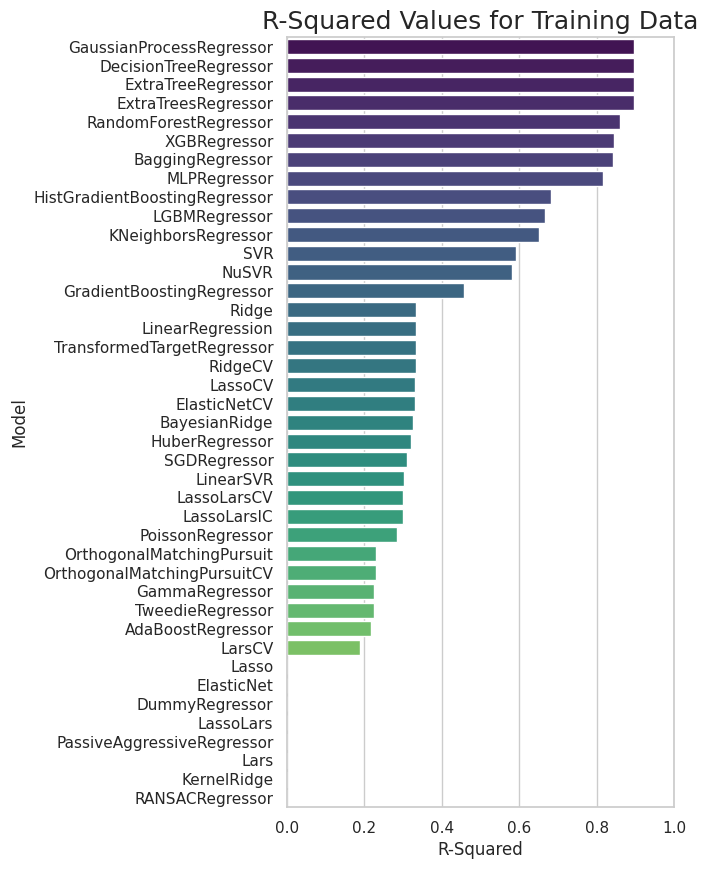

<Figure size 640x480 with 0 Axes>

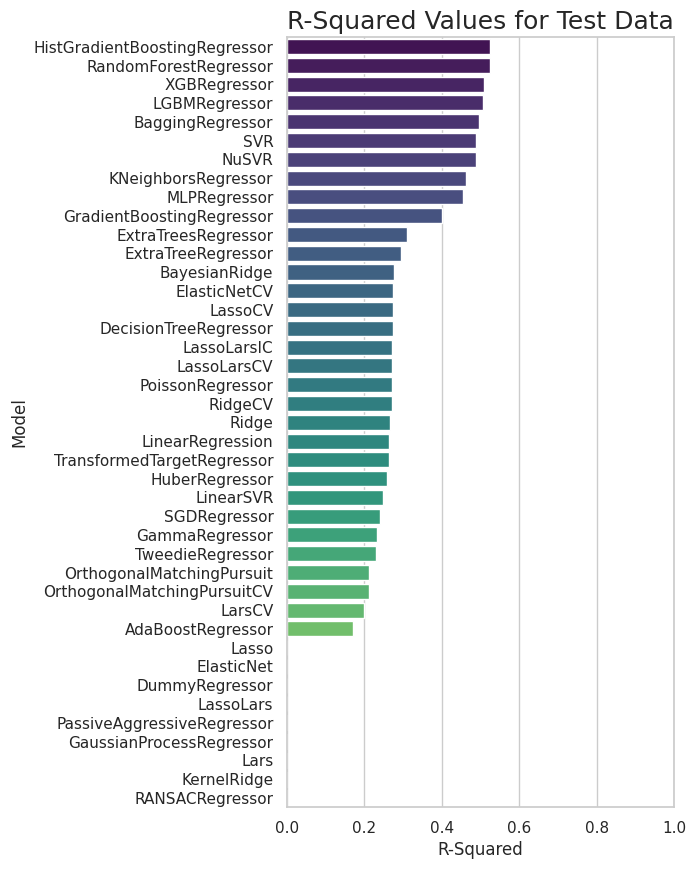

In [139]:
# Plot for Training Data
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train, palette="viridis")
ax1.set(xlim=(0, 1))
ax1.set_title('R-Squared Values for Training Data', fontsize=18)
plt.show()
plt.savefig("r2_train_plot.pdf", bbox_inches='tight')

# Plot for Test Data
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax2 = sns.barplot(y=predictions_test.index, x="R-Squared", data=predictions_test, palette="viridis")
ax2.set(xlim=(0, 1))
ax2.set_title('R-Squared Values for Test Data', fontsize=18)
plt.savefig("r2_test_plot.pdf", bbox_inches='tight')
plt.show()

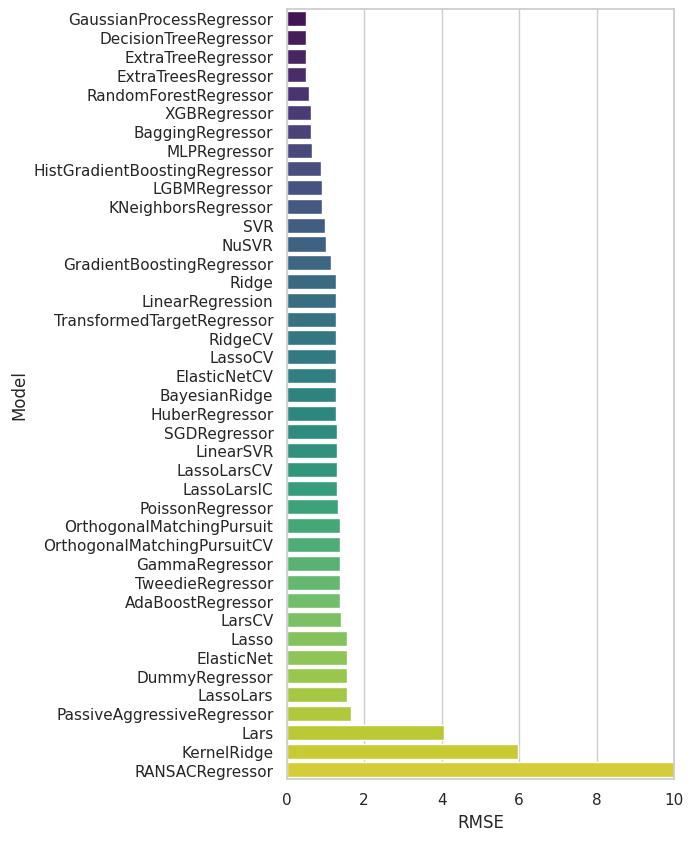

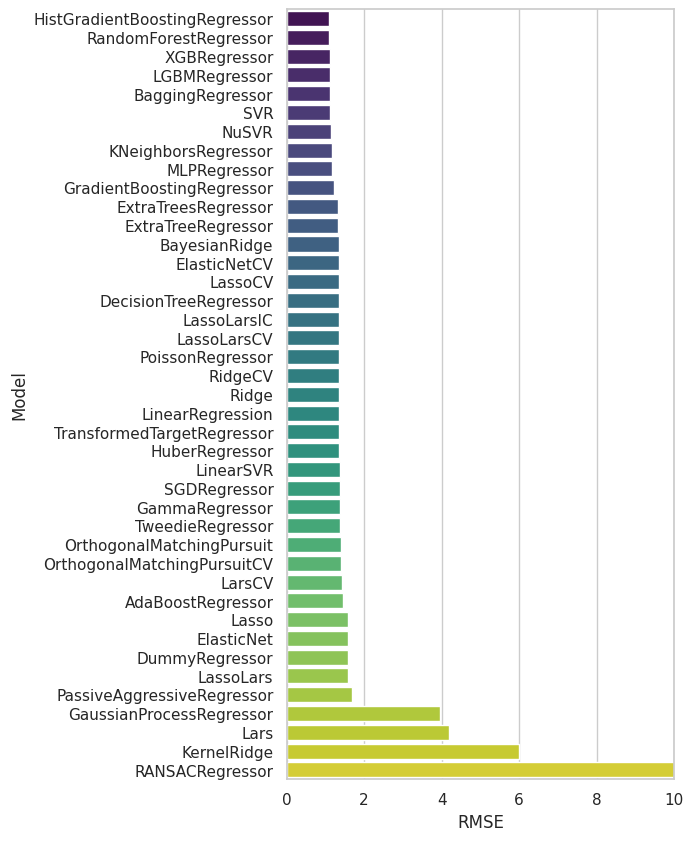

In [140]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train, palette="viridis")
ax2.set_title('RMSE for Train Data', fontsize=18)
ax.set(xlim=(0, 10))
plt.savefig("rmse_train_plot.pdf", bbox_inches='tight')

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_test.index, x="RMSE", data=predictions_test, palette="viridis")
ax2.set_title('RMSE for Test Data', fontsize=18)
ax.set(xlim=(0, 10))
plt.savefig("rmse_test_plot.pdf", bbox_inches='tight')

plt.show()

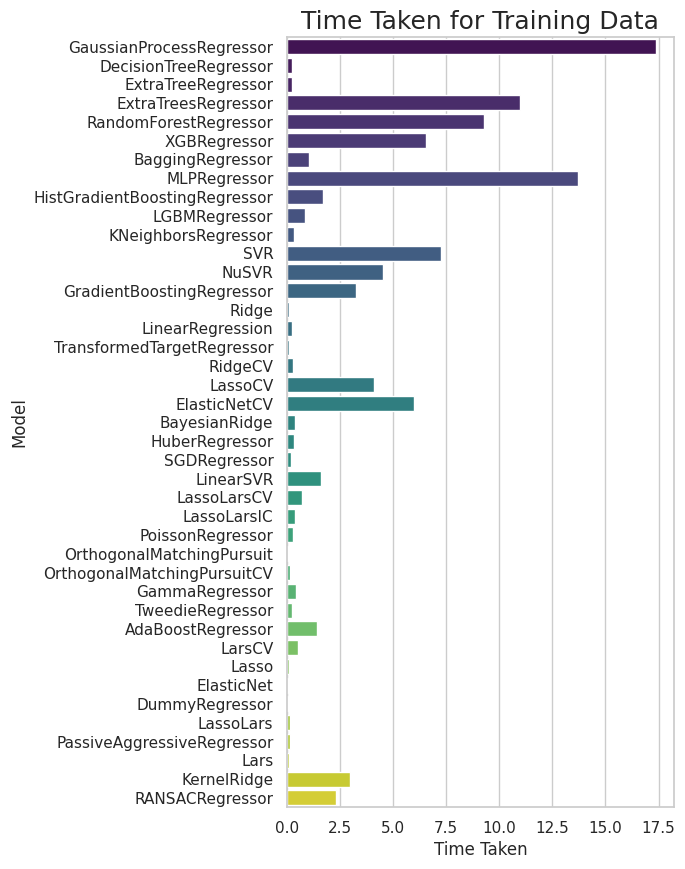

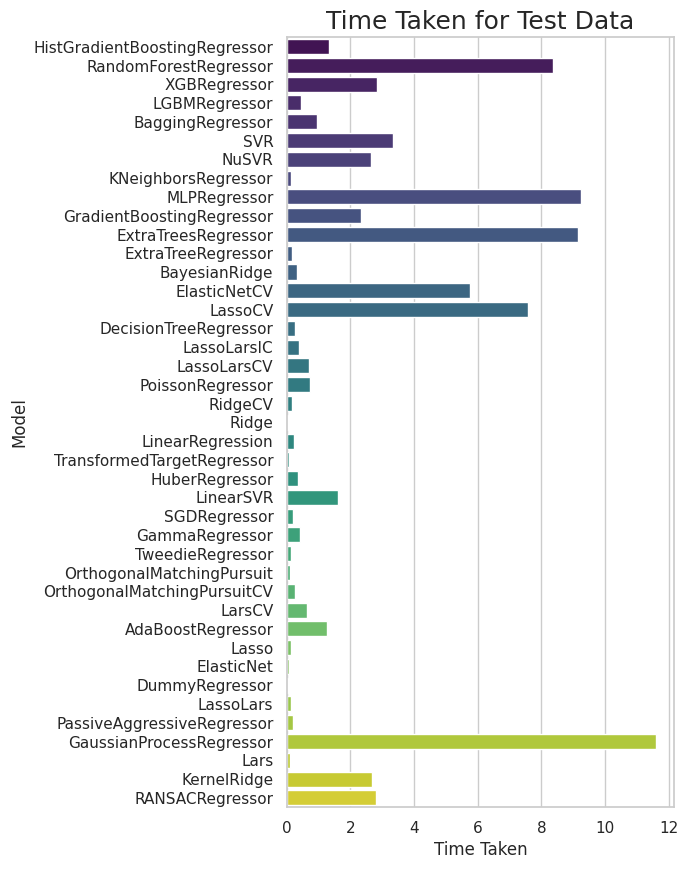

In [141]:
# Plot for Time Taken (Training Data)
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax3 = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train, palette="viridis")
ax3.set_title('Time Taken for Training Data', fontsize=18)
plt.savefig("time_train_plot.pdf", bbox_inches='tight')
plt.show()

# Plot for Time Taken (Test Data)
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax4 = sns.barplot(y=predictions_test.index, x="Time Taken", data=predictions_test, palette="viridis")
ax4.set_title('Time Taken for Test Data', fontsize=18)
plt.savefig("time_test_plot.pdf", bbox_inches='tight')
plt.show()

In [142]:
! cp /content/time_test* /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [143]:
! cp /content/rmse_* /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [144]:
! cp /content/r2_* /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

## 4.6 Analysis of Model Performance<a id = 47></a>

To determine the best method considering the balance of \( R^2 \), RMSE, and computational cost (time taken):

1. **Performance**: A higher \( R^2 \) value indicates a better fit of the model, and a lower RMSE indicates lower prediction errors. We prefer models with high \( R^2 \) and low RMSE on the **test** set because they generalize well to unseen data.
2. **Computational Cost**: We prefer models that are computationally efficient, i.e., have lower time taken values. However, a slightly higher computational cost might be acceptable if the model performs significantly better.

* **Random Forest:**
- Test \( R^2 \): 0.52
- Test RMSE: 1.09
- Time Taken: 6.19 seconds

* **HistGradientBoostingRegressor:**
- Test \( R^2 \): 0.53
- Test RMSE: 1.09
- Time Taken: 5.43 seconds

* **LGBMRegressor:**
- Test \( R^2 \): 0.51
- Test RMSE: 1.11
- Time Taken: 0.46 seconds

Considering the previous observations:

- The **HistGradientBoostingRegressor** and **Random Forest** have almost the same performance on the test set, but **HistGradientBoostingRegressor** is slightly more time-efficient.
- **LGBMRegressor**, on the other hand, is extremely fast and offers performance close to the top models.



# 5. Random Forest<a id = 48></a>

## 5.1 Importing Libraries<a id = 49></a>

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 5.2 Input Features<a id = 50></a>

In [146]:
X.shape

(6156, 144)

In [147]:
Y.shape

(6156,)

## 5.3 Random Forest Regression Model<a id = 51></a>

In [148]:
rf_model = RandomForestRegressor(random_state = 5, n_estimators=100)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=5)

In [149]:
Y_pred_train = rf_model.predict(X_train)
Y_pred_test = rf_model.predict(X_test)

In [150]:
Y_pred_test

array([5.76202471, 6.83052183, 5.46659329, ..., 4.43112145, 7.12913847,
       7.35528385])

In [151]:
# Calculating performance metrics for the training set
rmse_train = mean_squared_error(Y_train, Y_pred_train, squared=False) #squared=False gives the rmse instead of the mse
r2_train = r2_score(Y_train, Y_pred_train)

In [152]:
# Calculating performance metrics for the test set
rmse_test = mean_squared_error(Y_test, Y_pred_test, squared=False)
r2_test = r2_score(Y_test, Y_pred_test)

In [153]:
data = {
    'Metric': ['RMSE', 'R^2'],
    'Training Data': [rmse_train, r2_train],
    'Test Data': [rmse_test, r2_test]
}

df_metrics = pd.DataFrame(data)
df_metrics.set_index('Metric', inplace=True)
print(df_metrics)

        Training Data  Test Data
Metric                          
RMSE             0.59       1.10
R^2              0.86       0.52


**Random Forest Regressor Model Performance**

**Training Data:**
- **RMSE (Root Mean Squared Error):** 0.59
- **R^2 (Coefficient of Determination):** 0.86
- These results are in close agreement with the observations from the lazypredict in the previous section.

**Test Data:**
- **RMSE (Root Mean Squared Error):** 1.10
- **R^2 (Coefficient of Determination):** 0.52
- The results are also in agreement with the previous observations.

The model explains approximately 77% of the variance in the training set, but this drops to around 52% in the test set. The RMSE values indicate that the model's predictions have an average error of about 0.59 for the training set and 1.10 for the test set.

It's evident that the model performs better on the training set than on the test set. Further optimization or regularization might help in achieving a better balance between training and testing performance.

## 5.4 Experimental vs Predicted pIC50 Values<a id = 52></a>

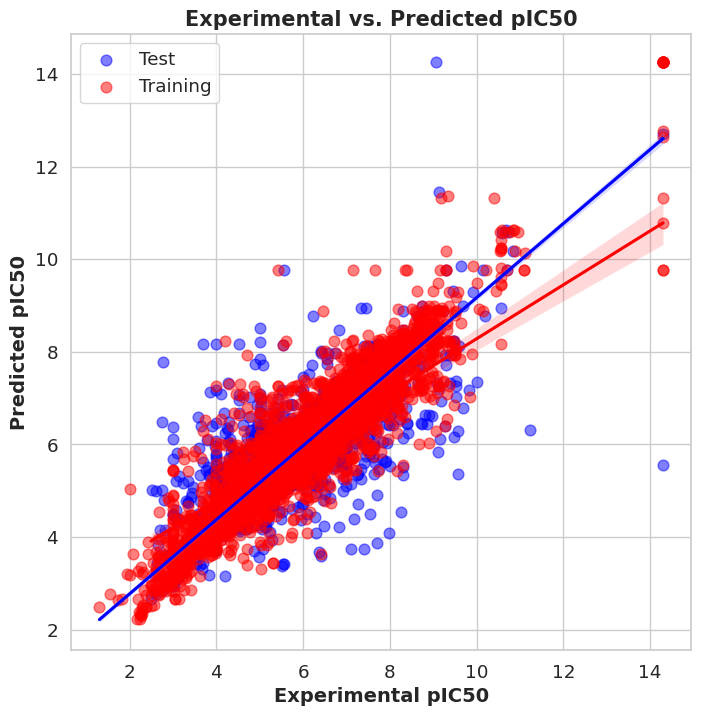

In [154]:
# Set style and context
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the regplot
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=Y_test, y=Y_pred_test, scatter_kws={'alpha':0.5, 's':60}, color='blue', line_kws={'color':'red'}, label="Test")
ax = sns.regplot(x=Y_train, y=Y_pred_train, scatter_kws={'alpha':0.5, 's':60}, color='red', line_kws={'color':'blue'}, label="Training")

# Customize the plot details
ax.set_title('Experimental vs. Predicted pIC50', fontsize=15, fontweight='bold')
ax.set_xlabel('Experimental pIC50', fontsize=14, fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize=14, fontweight='bold')
plt.savefig("pIC50_exp_vs_pedicted.pdf", bbox_inches='tight')

# Display the plot
plt.legend()
plt.show();

## 5.5 Residuals<a id = 53></a>

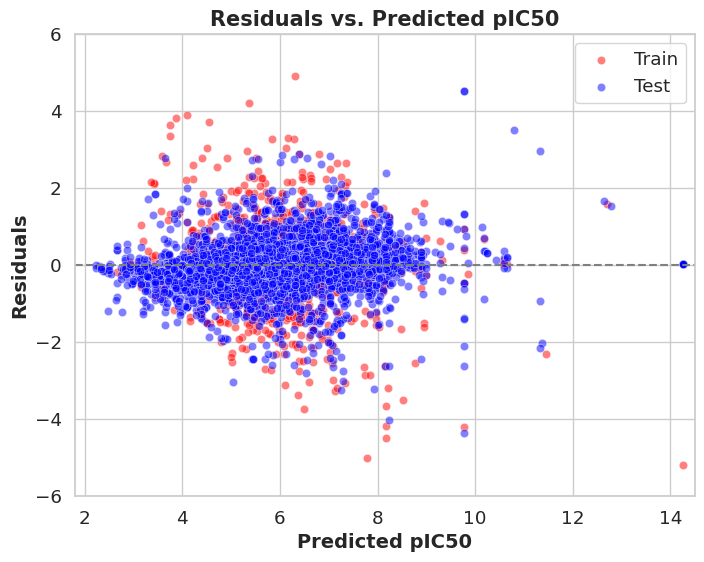

In [155]:
# Calculate the residuals
residuals_test = Y_test - Y_pred_test
residuals_train = Y_train - Y_pred_train

# Set style and context for a more appealing plot
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the residuals plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=Y_pred_test, y=residuals_test, alpha=0.5, color='red', label='Train')
ax = sns.scatterplot(x=Y_pred_train, y=residuals_train, alpha=0.5, color='blue', label='Test')

# Plot a horizontal line at y=0 for reference
plt.axhline(0, color='grey', linestyle='--')

# Customize the plot details
ax.set_title('Residuals vs. Predicted pIC50', fontsize=15, fontweight='bold')
ax.set_xlabel('Predicted pIC50', fontsize=14, fontweight='bold')
ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
ax.set_xlim(1.8, 14.5)
ax.set_ylim(-6, 6)

plt.savefig("residuals.pdf", bbox_inches='tight')
plt.legend()
plt.show()

In [156]:
! cp /content/pIC50_exp_vs_pedicted.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

In [157]:
! cp /content/residuals.pdf /content/drive/MyDrive/Chemoinformatics/Projects/acetylcholinesterase_2016/images

## 5.6 Analysis of the Visualization<a id = 54></a>

From the plots, we can see that the model performs reasonably well on the training data, with the predictions clustering closely around the ideal line. However, there's more spread in the test data predictions, indicating that the model isn't as effective on unseen data. The residuals plot scatter fairly randomly around the zero line, the test data residuals might have a more noticeable pattern, maybe suggesting there might be systematic errors in the model's predictions on new data.

# 6. Hyperparameters<a id = 55></a>


## 6.1 Importing<a id = 56></a>


In [158]:
from sklearn.model_selection import RandomizedSearchCV

## 6.2 Defining the Hyperparameters grid<a id = 57></a>

In [159]:
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(1, 20),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'bootstrap': [True, False]
}

## 6.3 Initializing the GridSearchCV<a id = 58></a>

In [160]:
rf = RandomForestRegressor(random_state = 5)
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1)

In [161]:
rf_random_search.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=5),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=1)

In [162]:
rf_best_params = rf_random_search.best_params_
print(rf_best_params)

{'n_estimators': 130, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 16, 'bootstrap': True}


In [163]:
random_forest_hyper = RandomForestRegressor(random_state=5, n_estimators=30, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=12, bootstrap= True)

In [164]:
# Fitting the model
random_forest_hyper.fit(X_train, Y_train)

RandomForestRegressor(max_depth=12, max_features='auto', min_samples_leaf=2,
                      n_estimators=30, random_state=5)

In [165]:
# Evaluating the models on the test data
rf_test_preds_hyper = random_forest_hyper.predict(X_test)

# Calculating performance metrics for the test set
rmse_test_hyper = mean_squared_error(Y_test, rf_test_preds_hyper, squared=False)
r2_test_hyper = r2_score(Y_test, rf_test_preds_hyper)
print(rmse_test_hyper, r2_test_hyper)

1.0918238743546518 0.5247672591526725


In [166]:
results_rf_hyper = {
    'Model': ['Random Forest', 'Random Forest Hyperparameters'],
    'RMSE': [rmse_test, rmse_test_hyper],
    'R^2': [r2_test, r2_test_hyper]
}

# Creating a DataFrame from the results
results_rf2 = pd.DataFrame(results_rf_hyper)

results_rf2

Model  RMSE  R^2
0                  Random Forest  1.10 0.52
1  Random Forest Hyperparameters  1.09 0.52

## 6.4 Results<a id = 59></a>

There is not a real improvement of the algorithm after tunning the hyperparameters using the RandomizedSearchCV as the RMSE and R^2 show.

# 7. 10-fold cross-validation<a id = 60></a>


## 7.1 Importing Libraries<a id = 61></a>

In [167]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 7.2 Set Up 10-Fold CV<a id = 62></a>

In [168]:
kf = KFold(n_splits=10, shuffle=True, random_state=5)

In [169]:
rf_model = RandomForestRegressor(random_state=5, n_estimators=100)

rmse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    Y_train_fold, Y_test_fold = Y[train_index], Y[test_index]

    rf_model.fit(X_train_fold, Y_train_fold)
    Y_pred_fold = rf_model.predict(X_test_fold)

    rmse_fold = mean_squared_error(Y_test_fold, Y_pred_fold, squared=False)
    r2_fold = r2_score(Y_test_fold, Y_pred_fold)

    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

average_rmse = sum(rmse_scores) / len(rmse_scores)
average_r2 = sum(r2_scores) / len(r2_scores)

print(f"Average RMSE across folds: {average_rmse:.2f}")
print(f"Average R^2 across folds: {average_r2:.2f}")

Average RMSE across folds: 1.06
Average R^2 across folds: 0.54


## 7.3 Results<a id = 63></a>

In [170]:
results_rf_cv = {
    'Model': ['Random Forest', 'Random Forest Hyperparameters', 'Random Forest CV'],
    'RMSE': [rmse_test, rmse_test_hyper, average_rmse],
    'R^2': [r2_test, r2_test_hyper, average_r2]
}

# Creating a DataFrame from the results
results_rf3 = pd.DataFrame(results_rf_cv)

results_rf3

Model  RMSE  R^2
0                  Random Forest  1.10 0.52
1  Random Forest Hyperparameters  1.09 0.52
2               Random Forest CV  1.06 0.54

1. The **Random Forest with Cross-Validation (CV)** has the best performance among the three. It has the lowest RMSE (1.06) and the highest R^2 (0.54), which means it predicts more accurately and explains more of the variance in the data compared to the other two models.

2. The **Random Forest with Hyperparameters** has a slightly better RMSE (1.09) compared to the basic Random Forest (1.10), but their R^2 values are the same (0.52). This suggests that hyperparameter tuning provided a minor improvement in prediction accuracy but didn't significantly change the proportion of variance explained.

3. The **basic Random Forest** has the highest RMSE (1.10) and a lower R^2 (0.52) compared to the CV model, indicating it's the least accurate of the three.

The Random Forest model with Cross-Validation is the best model among the three based on the provided metrics. It offers the most accurate predictions and explains the most variance in the data. However, it's essential to note that while these metrics provide a good indication of model performance, the choice of the best model might also depend on other factors like computational cost, interpretability, and specific project requirements.

# 8. Conclusions<a id = 64></a>

The project objective was to reproduce the previous published data of a 2016 publication called: **"Probing the origins of human acetylcholinesterase inhibition via QSAR modeling and molecular docking"**<sup><a href="#ref5">[5]</a></sup>: https://doi.org/10.7717/peerj.2322

The project is an exploration of the bioactivity data related to Human Acetylcholinesterase, a critical target in drug discovery. Beginning with an introduction to the ChEMBL Database, the data was processed and curated, ensuring its interpretability for subsequent analysis. This involved handling missing data, classifying compounds based on their bioactivity, and converting IC50 values to a more interpretable pIC50 scale.

During exploratory data analysis, the relationships between various Lipinski Descriptors and pIC50 values was reviewd and rationalized. Furthermore, the Mann-Whitney U Test offered a statistical perspective on the differences between active and inactive molecules across various descriptors.

Before proceeding with the ML modeling, the PaDEL's software was used to compute several fingerprint descriptors.

The Random Forest regression model was chosen based on a good trade-off between performance and computational cost.

In summary, this project exemplifies a meticulous approach for the QSAR modeling of a biological target utilizing several state-of-the-art computational tools applied to ML in drug discovery.

# 9. References<a id = 65></a>

<ol>
<li id="ref1"><a href="https://doi.org/10.1038/35067589" target="_blank">Soreq, H.; Seidman, S. Acetylcholinesterase — new roles for an old actor. <i>Nature Reviews Neuroscience</i> 2001, 2, 294-302.</a></li>

<li id="ref2"><a href="https://doi.org/10.1093/ageing/afs165" target="_blank">Hyde, C.; Peters, J.; Bond, M.; Rogers, G.; Hoyle, M.; Anderson, R.; Jeffreys, M.; Davis, S.; Thokala, P.; Moxham, T. Evolution of the evidence on the effectiveness and cost-effectiveness of acetylcholinesterase inhibitors and memantine for Alzheimer's disease: systematic review and economic model. <i>Age and ageing</i> 2013, 42 (1), 14-20.</a></li>

<li id="ref3"><a href="https://doi.org/10.1002/ps.3770" target="_blank">Chang, C.; Cheng, X.; Huang, X.Y.; Dai, S. Amino acid substitutions of acetylcholinesterase associated with carbofuran resistance in Chilo suppressalis. <i>Pest management science</i> 2014, 70 (12), 1930-5.</a></li>

<li id="ref4"><a href="https://doi.org/10.1016/j.taap.2011.06.021" target="_blank">Duysen, E.; Lockridge, O. Induction of plasma acetylcholinesterase activity in mice challenged with organophosphorus poisons. <i>Toxicology and applied pharmacology</i> 2011, 255 (2), 214-20.</a></li>
<li id="ref5"><a href="https://doi.org/10.7717/peerj.2322" target="_blank">Simeon, S.; Anuwongcharoen, N.; Shoombuatong, W.; Malik, A.A.; Prachayasittikul, V.; Wikberg, J.E.S.; Nantasenamat, C. Probing the origins of human acetylcholinesterase inhibition via QSAR modeling and molecular docking. <i>PeerJ</i> 2016, 4, e2322.</a></li>
<li id="ref6"><a href="https://doi.org/10.1186/s12929-014-0084-0" target="_blank">Wong, K.Y.; Mercader, A.G.; Saavedra, L.M.; Honarparvar, B.; Romanelli, G.; Duchowicz, P. QSAR analysis on tacrine-related acetylcholinesterase inhibitors. <i>J Biomed Sci</i> 2014, 21, 84.</a></li>
<li id="7"><a href="https://doi.org/10.1093/nar/gkr777" target="_blank">Gaulton, A.; Bellis, L.J.; Bento, A.P.; Chambers, J.; Davies, M.; Hersey, A.; Light, Y.; McGlinchey, S.; Michalovich, D.; Al-Lazikani, B.; Overington, J.P. ChEMBL: a large-scale bioactivity database for drug discovery. <i>Nucleic Acids Res.</i> 2012, 40(Database issue), D1100-7.</a></li>
<li id="8"><a href="https://www.sciencedirect.com/science/article/abs/pii/S0169409X96004231" target="_blank">Lipinski, C. A.; Lombardo, F.; Dominy, B. W.; Feeney, P. J. Experimental and computational approaches to estimate solubility and permeability in drug discovery and development settings. <i>Advanced Drug Delivery Reviews</i> 1997, Volume 23, Issues 1–3, Pages 3-25.</a></li>
<li id="9"><a href="https://www.jstor.org/stable/2236101" target="_blank">Mann, H.B.; Whitney, D.R. On a Test of Whether one of Two Random Variables is Stochastically Larger than the Other. <i>Ann. Math. Statist.</i> 1947, 18(1), 50-60.</a></li>
<li id="10"><a href="https://onlinelibrary.wiley.com/doi/abs/10.1002/jcc.21707" target="_blank">Yap, C. W. PaDEL-descriptor: An open-source software to calculate molecular descriptors and fingerprints<i>Journal of Computational Chemistry</i> 2011, 32(7), 1466-1474.</a></li>


</ol>

